# Transcription Factor Project - Code Testing

**Robin Anwyl, UCSD Subramaniam Lab**

In [2]:
# import muon as mu
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
#import re
#import requests
import gc
#from plotnine import ggplot, aes, geom_bar, ggtitle, xlab, ylab, scale_fill_manual, geom_histogram, labs, theme, element_text, scale_y_continuous
#from sklearn.ensemble import IsolationForest
#from sklearn.svm import OneClassSVM
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import gamma
from scipy.stats import spearmanr
import seaborn as sns
#import dcor
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import networkx as nx
# from pydeseq2.dds import DeseqDataSet
# from pydeseq2.ds import DeseqStats
# from pydeseq2.default_inference import DefaultInference
#import openpyxl
from IPython.display import display  #type: ignore
from scipy.spatial.distance import pdist, squareform #type: ignore
import plotly.express as px #type: ignore
import plotly.graph_objects as go #type: ignore
import pymde #type: ignore
import plotly.io as pio #type: ignore
from sklearn.preprocessing import StandardScaler #type: ignore
from sklearn.neighbors import kneighbors_graph #type: ignore
from sklearn.manifold import SpectralEmbedding
import igraph as ig #type: ignore
import leidenalg #type: ignore
import sys
import os
sys.path.insert(0, "/home/ranwyl/data_tf_project/")
import perturb_seq_heuristic_pipeline as qc
import pan_genome_analysis_functions as qc2

# Differential expression analysis (DEA) during full dataset QC

### Modifying and testing code for Step G

3/12:
-  Started with 12GB RAM used
-  Then read in `adata_alpha`, usage = 28GB (so `adata_alpha` uses 16GB RAM)
-  Changed `adata.alpha.X` to the raw counts, usage = 18GB (so `adata_alpha` now uses 6GB RAM)
-  Took 27 seconds to run differential expression analysis on 2 gene targets out of 1466, now usage = 36GB. 24GB is used by me, 6GB for `adata_alpha` and 9GB for DEA results for each gene target

3/13
-  Started with 110GB RAM used
-  Read in `adata_alpha` and changed X to raw counts, usage = 116GB
-  Ran DEA on 4 gene targets which took 50 seconds, usage = 133GB, 17GB/4 = 4.25GB per gene target
-  Restarted kernel and then ran DEA on 10 gene targets which took 2 minutes, usage = 133GB = 17GB/10 = 1.7GB per gene target
-  Restarted kernel and then ran DEA on 50 gene targets which took 9min 39s, usage = 135GB-116GB = 18GB/50 = 0.36GB per gene target

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_alpha.X = adata_alpha.layers["counts"].copy()

In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")

Determine how many gene targets are in each ALPHA, BETA, GAMMA batch
-  ALPHA: 1466 gene targets
-  BETA: 1695 gene targets
-  GAMMA: 1069 gene targets

In [ ]:
def get_gene_targets(adata):
    gene_targets = list(adata.obs["gene_target"].unique())
    gene_targets.remove("NTC")  # Remove the control group
    return gene_targets
gene_targets_alpha = get_gene_targets(adata_alpha)
gene_targets_beta = get_gene_targets(adata_beta)
gene_targets_gamma = get_gene_targets(adata_gamma)
print(f"ALPHA: {len(gene_targets_alpha)} gene targets")
print(f"first 10 gene targets in ALPHA: {gene_targets_alpha[:10]}")
print(f"first 10 gene targets in ALPHA, sorted: {sorted(gene_targets_alpha)[:10]}")
print(f"BETA: {len(gene_targets_beta)} gene targets")
print(f"first 10 gene targets in BETA: {gene_targets_beta[:10]}")
print(f"first 10 gene targets in BETA, sorted: {sorted(gene_targets_beta)[:10]}")
print(f"GAMMA: {len(gene_targets_gamma)} gene targets")
print(f"first 10 gene targets in GAMMA: {gene_targets_gamma[:10]}")
print(f"first 10 gene targets in GAMMA, sorted: {sorted(gene_targets_gamma)[:10]}")

ALPHA: 1466 gene targets
first 10 gene targets in ALPHA: ['DMRT2', 'CREBBP', 'SIRT1', 'OSR2', 'RAD51B', 'AARS2', 'CELF2', 'SUPV3L1', 'H3C12', 'BHLHA9']
first 10 gene targets in ALPHA, sorted: ['AACS', 'AARS2', 'AASDH', 'AATF', 'ABCF1', 'ABRAXAS1', 'ACAD8', 'ACSBG1', 'ACSBG2', 'ACSF2']
BETA: 1695 gene targets
first 10 gene targets in BETA: ['ACTN1', 'TWSG1', 'IFFO1', 'FDXACB1', 'LYPLA2', 'ZFAND1', 'ATP1A3', 'JOSD1', 'CHP2', 'TMUB1']
first 10 gene targets in BETA, sorted: ['AAAS', 'AAR2', 'AARD', 'AASS', 'ABCA2', 'ABCD4', 'ABHD13', 'ABHD17A', 'ABHD17C', 'ABHD4']
GAMMA: 1069 gene targets
first 10 gene targets in GAMMA: ['STIMATE', 'ESRP2', 'BECN1', 'FZD3', 'MPND', 'GLA', 'EEIG2', 'HMCN2', 'GLCCI1', 'LYN']
first 10 gene targets in GAMMA, sorted: ['ABCB10', 'ABCC5', 'ABCG1', 'ABHD11', 'ABHD12', 'ABI1', 'ABRACL', 'ACBD4', 'ACCS', 'ACER2']


Write function `test_run_deseq2_analysis()` that runs the same code as `run_deseq2_analysis()` on a smaller subset of genes

In [ ]:
def test_run_deseq2_analysis(adata, n_gene_targets, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", n_replicates=3, sample_fraction=0.7, layer=None, alpha=0.05):
    ntc_cells = np.where(adata_alpha.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata_alpha.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group

    def process_gene_target(gene_target):
            pseudo_bulk_df, metadata_df = qc2.generate_pseudo_bulk_replicates_for_de(
                adata, gene_target, ntc_cells, n_replicates=n_replicates, sample_fraction=sample_fraction, layer=layer
            )
            return qc2.deseq2(pseudo_bulk_df, metadata_df, contrast=["condition", gene_target, ntc_cells_delimiter], alpha=alpha)
    
    results = list()
    for gene_target in gene_targets[:n_gene_targets]:
          results.append(process_gene_target(gene_target))
    results_dict = dict(zip(gene_targets, results))
    return results_dict

Run `test_run_deseq2_analysis()` on 16 gene targets with no parallelization. Used 18GB RAM.

In [ ]:
alpha16 = test_run_deseq2_analysis(adata_alpha, 16)

Write slightly modified version of `run_deseq2_analysis()` where `n_jobs` (number of jobs to run in parallel using multiple CPUs) is not set to all available CPUs by default

In [ ]:
def test_run_deseq2_analysis_parallel(adata, n_gene_targets, n_jobs, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", n_replicates=3, sample_fraction=0.7, layer=None, alpha=0.05):
    ntc_cells = np.where(adata.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group

    def process_gene_target(gene_target):
        pseudo_bulk_df, metadata_df = qc2.generate_pseudo_bulk_replicates_for_de(
            adata, gene_target, ntc_cells, n_replicates=n_replicates, sample_fraction=sample_fraction, layer=layer
        )
        return qc2.deseq2(pseudo_bulk_df, metadata_df, contrast=["condition", gene_target, ntc_cells_delimiter], alpha=alpha)

    gene_targets = gene_targets[:n_gene_targets] # Subset gene targets for testing
    print(f"Number of gene targets: {len(gene_targets)}")
    with tqdm_joblib(desc="Running DE analysis", total=len(gene_targets)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_gene_target)(gene_target) for gene_target in gene_targets)
    
    results_dict = dict(zip(gene_targets, results))
    
    return results_dict

Read in data

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_alpha.X = adata_alpha.layers["counts"].copy()

**Test parallel processing where number of gene targets = number of CPUs**

Run `test_run_deseq2_analysis_parallel()` with 2 gene targets and 2 CPUs
-  Before starting kernel: usage = 113GB RAM
-  After data, before running alpha16_parallel: usage = 119GB
-  While running: usage = 160GB

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 2, 2)

Number of gene targets: 2


Running DE analysis:   0%|          | 0/2 [00:00<?, ?it/s]

Run `test_run_deseq2_analysis_parallel()` with 4 gene targets and 4 CPUs
-  Before starting kernel: usage = 113GB RAM
-  After data, before running alpha16_parallel: usage = 119GB
-  While running: usage = 196GB

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 4, 4)

Number of gene targets: 4


Running DE analysis:   0%|          | 0/4 [00:00<?, ?it/s]

Run `test_run_deseq2_analysis_parallel()` with 8 gene targets and 8 CPUs
-  Before starting kernel: usage = 113GB RAM
-  After data, before running alpha16_parallel: usage = 119GB
-  First jumps up to 126GB, then all the way to 267GB

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 8, 8)

Number of gene targets: 8


Running DE analysis:   0%|          | 0/8 [00:00<?, ?it/s]

/home/ranwyl/venv311/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


Run `test_run_deseq2_analysis_parallel()` with 16 gene targets and 16 CPUs
-  Before: 119GB
-  Immediate increase: 119GB -> 128GB
-  Max usage: 409GB

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 16, 16)

Number of gene targets: 16


Running DE analysis:   0%|          | 0/16 [00:00<?, ?it/s]

**Test parallel processing where number of gene targets = 2 * number of CPUs**

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 4, 2) # 119 -> 126 -> 160GB

Number of gene targets: 4


Running DE analysis:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 8, 4) # 119 -> 126 -> 196

Number of gene targets: 8


Running DE analysis:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 16, 8) # 120 -> 129 -> 267GB

Number of gene targets: 16


Running DE analysis:   0%|          | 0/16 [00:00<?, ?it/s]

/home/ranwyl/venv311/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 32, 16) # 119 -> 133 -> 408 -> 403

Number of gene targets: 32


Running DE analysis:   0%|          | 0/32 [00:00<?, ?it/s]

/home/ranwyl/venv311/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 64, 16) # 119 -> 131 -> 408

Number of gene targets: 64


Running DE analysis:   0%|          | 0/64 [00:00<?, ?it/s]

/home/ranwyl/venv311/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


Write modified function to save DEG DataFrame as .xlsx file

In [ ]:
def save_DEG_df(results_dict, p_threshold=0.05, save=True, filepath=None):
    # Initialize a dictionary to store columns for the final DataFrame
    final_dict = {}

    for gene_target, df in results_dict.items():
        # Filter the DataFrame based on the padj (adjusted p-value) threshold
        filtered_df = df[df['padj'] < p_threshold]

        # Sort by L2FC
        l2fc_sorted = filtered_df.sort_values('log2FoldChange')
        
        # Create columns for DEGs, L2FC, and Adj_P and add them to the final_dict
        final_dict[f'{gene_target}_DEGs'] = l2fc_sorted.index.tolist()
        final_dict[f'{gene_target}_L2FC'] = l2fc_sorted['log2FoldChange'].tolist()
        final_dict[f'{gene_target}_Adj_P'] = l2fc_sorted['padj'].tolist()

    # Group keys by gene target to maintain adjacency
    gene_targets = list(results_dict.keys())
    
    # Sort the gene targets by the number of DEGs
    sorted_gene_targets = sorted(gene_targets, key=lambda gt: len(final_dict[f'{gt}_DEGs']), reverse=True)
    
    # Reorder the final_dict to keep DEGs, L2FC, and Adj_P together for each gene target
    ordered_dict = {}
    for gene_target in sorted_gene_targets:
        ordered_dict[f'{gene_target}_DEGs'] = final_dict[f'{gene_target}_DEGs']
        ordered_dict[f'{gene_target}_L2FC'] = final_dict[f'{gene_target}_L2FC']
        ordered_dict[f'{gene_target}_Adj_P'] = final_dict[f'{gene_target}_Adj_P']

    # Find the maximum length of lists in the ordered_dict to handle unequal lengths
    max_length = max(len(lst) for lst in ordered_dict.values())

    # Pad shorter lists with None to ensure equal length columns
    for key in ordered_dict:
        ordered_dict[key].extend([None] * (max_length - len(ordered_dict[key])))

    # Create the final DataFrame directly from the dictionary
    combined_df = pd.DataFrame(ordered_dict)

    if save and filepath:
        with pd.ExcelWriter(filepath) as writer:
            combined_df.to_excel(writer, sheet_name='DEG Results', index=False)

In [ ]:
test_filepath = "/home/ranwyl/results_tf_project/ALPHA_DEGs_test2.xlsx"
save_DEG_df(results, filepath=test_filepath)

# Minimal distortion embedding (MDE)

## ClusterWarning error message

We want to test why we are getting the error message: 

"/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,"

In [ ]:
def compute_mean_normalized_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
    return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

def test_tf_compute_MDE(adata, n_jobs, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices

    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_normalized_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    
    # Convert the list of mean profiles to a numpy array
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack'
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    
    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    cluster_groups = embedding_df.groupby('cluster')
    centroids = cluster_groups[['x', 'y']].mean()
    pairwise_distances = pd.DataFrame(
        squareform(pdist(centroids, metric='euclidean')),
        index=centroids.index,
        columns=centroids.index
    )
    sns.clustermap(pairwise_distances, cmap='PuBuGn')
    plt.title('Pairwise Distance Matrix of Cluster Centroids')
    plt.show()


    # # Plot using Plotly with Pastel colormap for discrete clusters
    # fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
    #                  hover_data={'x': True, 'y': True, 'gene_target': True},
    #                  title='MDE Embedding of Mean Normalized Profiles',
    #                  color_discrete_sequence=px.colors.qualitative.Bold)
    # fig.update_traces(marker=dict(size=7,opacity=0.7),textposition='middle center',textfont=dict(size=4))
    
    
    # fig.update_layout(
    #     showlegend=True,
    #     xaxis=dict(visible=False),
    #     yaxis=dict(visible=False),
    #     plot_bgcolor='white',
    #     width=1200,  # Increase plot width
    #     height=1000,  # Increase plot height
    #     legend_title_text='Cluster',
    #     coloraxis_showscale=False
    # )
    # if not label_points:
    #     fig.update_traces(text=None)
   
    # fig.show()
    
    return adata, embedding, clusters, mean_profiles_array

def test_tf_compute_MDE_2(adata, n_jobs, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices

    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_normalized_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    
    # Convert the list of mean profiles to a numpy array
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack'
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    
    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    return embedding_df
    
    # pairwise_distances = pd.DataFrame(
    #     squareform(pdist(centroids, metric='euclidean')),
    #     index=centroids.index,
    #     columns=centroids.index
    # )
    # sns.clustermap(pairwise_distances, cmap='PuBuGn')
    # plt.title('Pairwise Distance Matrix of Cluster Centroids')
    # plt.show()

In [ ]:
adata_2012 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2012_genes.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 17 02:04:56 PM: Fitting a centered embedding into R^2, for a graph with 652 items and 128898 edges.
Apr 17 02:04:56 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 17 02:04:56 PM: iteration 0000 | distortion 0.974530 | residual norm 0.111911 | step length 1.73742 | percent change 0.538439
Apr 17 02:04:57 PM: iteration 0100 | distortion 0.139406 | residual norm 0.000115798 | step length 1 | percent change 0.30733
Apr 17 02:04:58 PM: iteration 0200 | distortion 0.137794 | residual norm 4.5249e-05 | step length 1 | percent change 0.0578183
Apr 17 02:05:00 PM: iteration 0300 | distortion 0.137382 | residual norm 6.20392e-05 | step length 1 | percent change 0.293795
Apr 17 02:05:01 PM: Converged in 385 iterations, with residual norm 8.46434e-06
Apr 17 02:05:01 PM: Finished fitting in 5.323 seconds and 385 iterations.
Apr 17 02:05:01 PM: average distortion 0.137 | residual norm 8.5e-06


/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


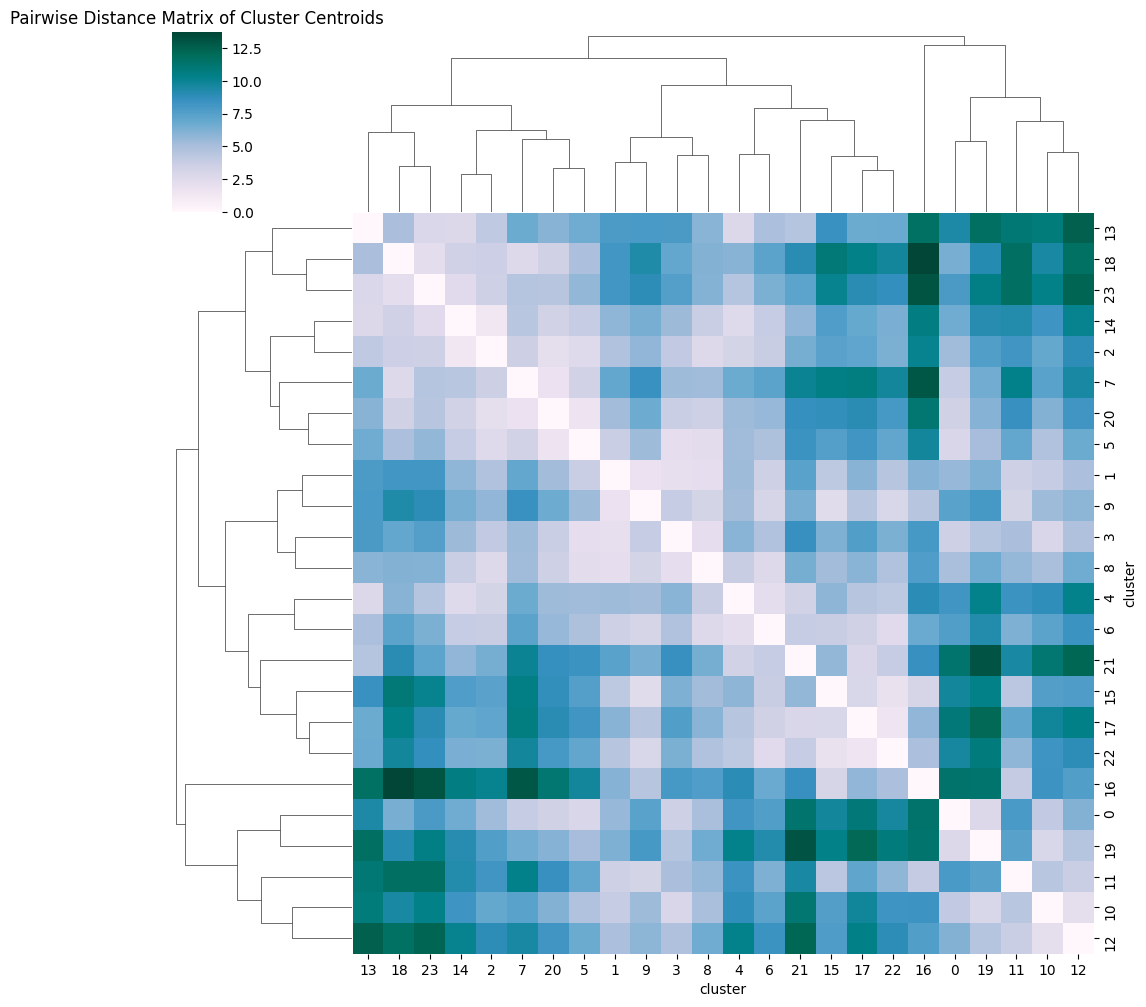

In [ ]:
test_adata, test_embedding, test_clusters, test_mp = test_tf_compute_MDE(adata_2012, 5, spectral=True, leiden_neighbors=8)

In [ ]:
test_embedding_df = test_tf_compute_MDE_2(adata_2012, 5, spectral=True, leiden_neighbors=8)

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 17 02:13:34 PM: Fitting a centered embedding into R^2, for a graph with 652 items and 128922 edges.
Apr 17 02:13:34 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 17 02:13:34 PM: iteration 0000 | distortion 0.973552 | residual norm 0.114345 | step length 0.311499 | percent change 0.0986355
Apr 17 02:13:37 PM: iteration 0100 | distortion 0.141704 | residual norm 0.000205405 | step length 1 | percent change 0.499116
Apr 17 02:13:40 PM: iteration 0200 | distortion 0.140230 | residual norm 0.000120667 | step length 0.631188 | percent change 0.733236
Apr 17 02:13:43 PM: iteration 0300 | distortion 0.139719 | residual norm 3.67199e-05 | step length 1 | percent change 0.130888
Apr 17 02:13:45 PM: iteration 0400 | distortion 0.139194 | residual norm 7.99929e-05 | step length 1 | percent change 0.424733
Apr 17 02:13:47 PM: iteration 0500 | distortion 0.138897 | residual norm 1.91764e-05 | step length 1 | percent change 0.044975
Apr 17 02:13:49 PM: iteration 06

In [ ]:
cluster_groups = test_embedding_df.groupby('cluster')
centroids = cluster_groups[['x', 'y']].mean()
centroids

,x,y
cluster,,
0,-0.046596,-0.406438
1,-1.316051,1.885311
10,1.190665,-1.900266
11,0.748815,1.298265
12,-1.312611,-5.399751
13,-4.194056,3.612322
14,6.250611,-1.030417
15,-7.694043,-0.612885
16,2.545876,1.978286


In [ ]:
pdist_mat = pdist(centroids, metric='euclidean')
pdist_mat.shape

(231,)

In [ ]:
pdist_mat

array([ 2.6198535 ,  1.93967396,  1.88114091,  5.15130746,  5.77510693,
        6.3280459 ,  7.65023314,  3.52247346,  7.27817722,  5.46037413,
        6.14163921,  2.96979007,  6.32561903,  7.54414014,  2.96502353,
        5.2201237 ,  4.53589409,  4.48038145,  4.00657474,  5.15274694,
        5.72957208,  4.54028841,  2.14669419,  7.28506336,  3.35640856,
        8.10899801,  6.8498005 ,  3.8630458 ,  5.38530643,  6.70946324,
        8.76019619,  4.12225246,  6.37593635,  5.02579284,  4.93712263,
        4.52461074,  3.21261507,  6.95650762,  6.54333446,  6.24502085,
        3.22394729,  3.22890523,  4.30264898,  7.70609141,  5.1341689 ,
        8.97749317,  4.10849859,  8.72348079,  5.59073271,  4.23297008,
        3.70818788,  7.26356072,  9.35354785,  2.10935912,  6.13952743,
        6.24879988,  2.63077424,  2.50027825,  4.7575672 ,  7.55060621,
        7.00805935,  5.45773171,  5.97432161,  8.65646275,  1.92142025,
        5.51913268,  7.2644011 ,  7.35726384,  4.68166575,  7.73

In [ ]:
squareform_mat = squareform(pdist_mat)
squareform_mat.shape

(22, 22)

In [ ]:
squareform_mat

array([[ 0.        ,  2.6198535 ,  1.93967396,  1.88114091,  5.15130746,
         5.77510693,  6.3280459 ,  7.65023314,  3.52247346,  7.27817722,
         5.46037413,  6.14163921,  2.96979007,  6.32561903,  7.54414014,
         2.96502353,  5.2201237 ,  4.53589409,  4.48038145,  4.00657474,
         5.15274694,  5.72957208],
       [ 2.6198535 ,  0.        ,  4.54028841,  2.14669419,  7.28506336,
         3.35640856,  8.10899801,  6.8498005 ,  3.8630458 ,  5.38530643,
         6.70946324,  8.76019619,  4.12225246,  6.37593635,  5.02579284,
         4.93712263,  4.52461074,  3.21261507,  6.95650762,  6.54333446,
         6.24502085,  3.22394729],
       [ 1.93967396,  4.54028841,  0.        ,  3.22890523,  4.30264898,
         7.70609141,  5.1341689 ,  8.97749317,  4.10849859,  8.72348079,
         5.59073271,  4.23297008,  3.70818788,  7.26356072,  9.35354785,
         2.10935912,  6.13952743,  6.24879988,  2.63077424,  2.50027825,
         4.7575672 ,  7.55060621],
       [ 1.88114091

## MDE randomness and duplicates in 5818-gene dataset

### Function

In [ ]:
def compute_mean_normalized_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
    return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

def tf_compute_MDE(adata, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices
    # Changed code to no longer compute mean normalized profiles in parallel -Robin
    mean_profiles = [compute_mean_normalized_profile(adata, indices) for indices in gene_target_groups.values()]
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    pymde.seed(42) # Added by Robin to make pymde.preserve_neighbors() deterministic
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack',
                random_state=42 # Added by Robin to make sklearn.SpectralEmbedding deterministic
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition, 
                                         seed=42 # Added by Robin to make leidenalg.find_partition() deterministic
                                         )
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    cluster_groups = embedding_df.groupby('cluster')
    centroids = cluster_groups[['x', 'y']].mean()
    pairwise_distances = pd.DataFrame(
        squareform(pdist(centroids, metric='euclidean')),
        index=centroids.index,
        columns=centroids.index
    )
    sns.clustermap(pairwise_distances, cmap='PuBuGn')
    plt.title('Pairwise Distance Matrix of Cluster Centroids')
    plt.show()

    # Plot using Plotly with Pastel colormap for discrete clusters
    fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
                     hover_data={'x': True, 'y': True, 'gene_target': True},
                     title='MDE Embedding of Mean Normalized Profiles',
                     color_discrete_sequence=px.colors.qualitative.Bold)
    fig.update_traces(marker=dict(size=7,opacity=0.7),textposition='middle center',textfont=dict(size=4))
    
    fig.update_layout(
        showlegend=True,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        plot_bgcolor='white',
        width=1200,  # Increase plot width
        height=1000,  # Increase plot height
        legend_title_text='Cluster',
        coloraxis_showscale=False
    )
    if not label_points: # Added by Robin
        fig.update_traces(text=None)
   
    fig.show()
    
    return adata, embedding, clusters, mean_profiles_array, embedding_df

def gene_targets_per_cluster(embedding_df):
    """
    Return DataFrame where each column contains the perturbations in a cluster.
    """
    cluster_nums = max([int(n) for n in set(embedding_df["cluster"].tolist())])
    cluster_dict = dict()
    for i in range(cluster_nums+1):
        cluster = embedding_df[embedding_df["cluster"] == str(i)]["gene_target"].tolist()
        cluster_dict[i] = cluster
    # Pad all columns to be the same length
    max_n_perts = max(len(cluster_dict[i]) for i in range(len(cluster_dict)))
    cluster_dict = {cluster:(perts + [""]*(max_n_perts-len(perts))) for cluster, perts in cluster_dict.items()}
    perts_in_cluster_df = pd.DataFrame(cluster_dict)
    return perts_in_cluster_df

In [3]:
adata_5818 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5818_degs.h5ad")

### Randomness

May 01 02:07:15 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
May 01 02:07:15 PM: The following items have duplicates [ 96 149 611]
May 01 02:07:15 PM: Fitting a centered embedding into R^2, for a graph with 652 items and 133179 edges.
May 01 02:07:15 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
May 01 02:07:15 PM: iteration 0000 | distortion 0.805415 | residual norm 3.04748 | step length 0.132789 | percent change 1.12063
May 01 02:07:17 PM: iteration 0100 | distortion 0.136475 | residual norm 0.000117066 | step length 1 | percent change 0.525486
May 01 02:07:18 PM: iteration 0200 | distortion 0.134152 | residual norm 7.32571e-05 | step length 1 | percent change 0.191992
May 01 02:07:19 PM: iteration 0300 | distortion 0.133623 | residual norm 3.656e-05 | step length 1 | percent change 0.189789
May 01 02:07:20 PM: iteration 0400 | distortion 0.133436 | residual norm 2.65137e-05 | step len

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



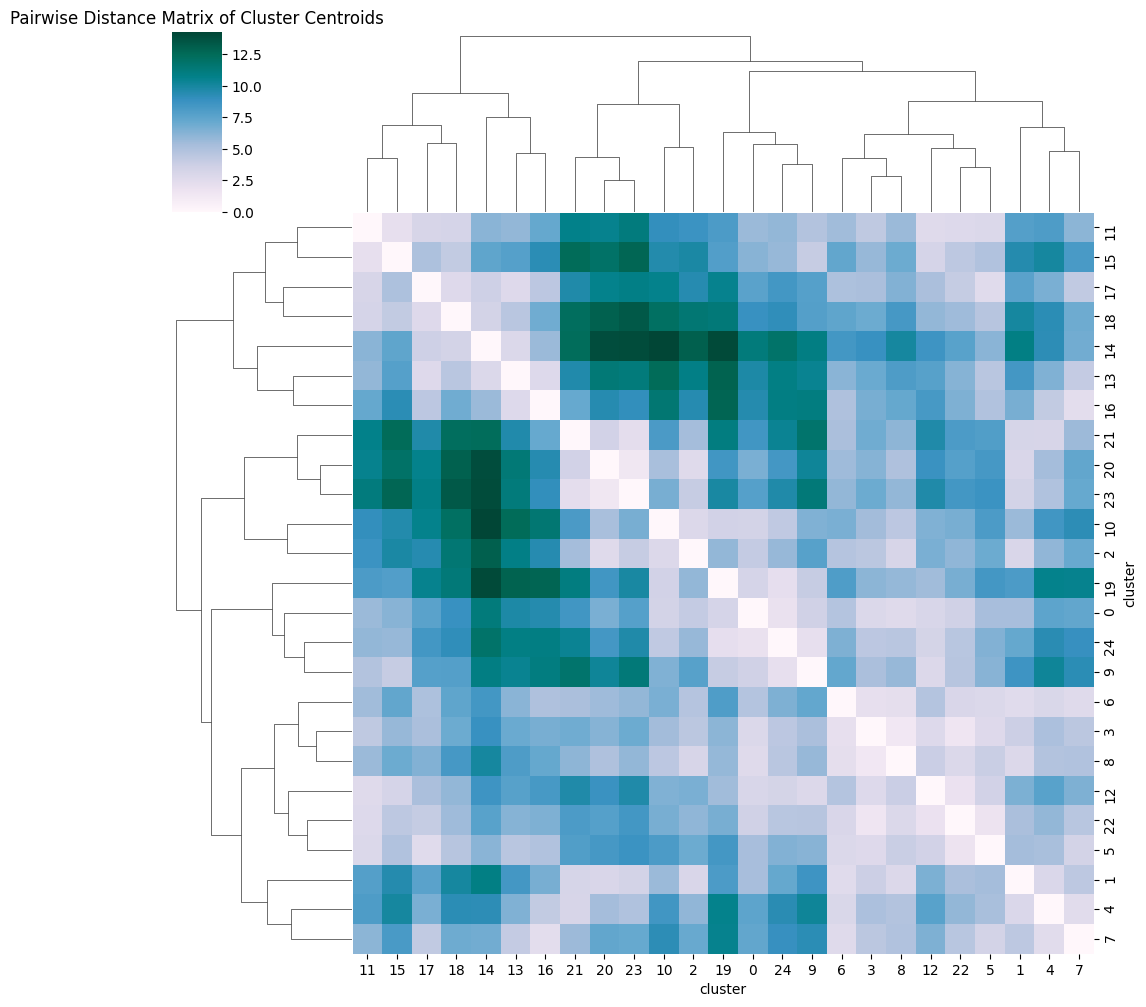

In [12]:
mde1 = tf_compute_MDE(adata_5818, spectral=True, leiden_neighbors=8)
_, _, _, _, embedding_df1 = mde1
cluster_df1 = gene_targets_per_cluster(embedding_df1)

In [16]:
cluster_df1.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,ARID2,AIRE,BHLHE41,DMRT3,ADNP2,ASCL5,ERF,AKAP8L,ASH1L,AHR,...,ATOH1,ARID3A,AKAP8,ARX,ASCL2,ANKZF1,BACH2,CREM,CREBL2,CEBPE
1,ARNT,ATOH7,ESRRA,FOXD4,ATF6B,BHLHA15,ERG,CAMTA2,BCL6B,ATMIN,...,CENPB,CREB5,BARHL1,CTCFL,FOXH1,FOXI2,FOXO1,ESR2,GATAD2B,CSRNP2
2,BHLHA9,CEBPB,FOXM1,FOXE3,DEAF1,DMRTA2,FOSB,CBX2,DLX6,CHAMP1,...,CENPS,GPBP1,GATA2,EHF,MTERF3,FOXJ1,HHEX,GATA3,MSANTD4,ZBTB6
3,CC2D1A,DMBX1,FOXN4,GATA1,DMRTC2,EBF3,GATAD2A,CREB3L4,EPAS1,DLX4,...,DR1,GRHL2,HSF2,ESX1,MTERF4,POU3F3,RARB,NKX6-2,PAX9,ZBTB21
4,CCDC17,ELF3,GBX1,HDX,ELK1,FOXA1,HNF1B,DACH2,FOXK2,DNMT1,...,DRAP1,HIC1,NFIB,FOSL1,NFE2L3,PPARA,SP2,NR1I3,ZNF12,ZFP1


May 01 02:07:49 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
May 01 02:07:49 PM: The following items have duplicates [ 96 149 611]
May 01 02:07:49 PM: Fitting a centered embedding into R^2, for a graph with 652 items and 133179 edges.
May 01 02:07:49 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
May 01 02:07:49 PM: iteration 0000 | distortion 0.805415 | residual norm 3.04748 | step length 0.132789 | percent change 1.12063
May 01 02:07:51 PM: iteration 0100 | distortion 0.136475 | residual norm 0.000117066 | step length 1 | percent change 0.525486
May 01 02:07:52 PM: iteration 0200 | distortion 0.134152 | residual norm 7.32571e-05 | step length 1 | percent change 0.191992
May 01 02:07:53 PM: iteration 0300 | distortion 0.133623 | residual norm 3.656e-05 | step length 1 | percent change 0.189789
May 01 02:07:54 PM: iteration 0400 | distortion 0.133436 | residual norm 2.65137e-05 | step len

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



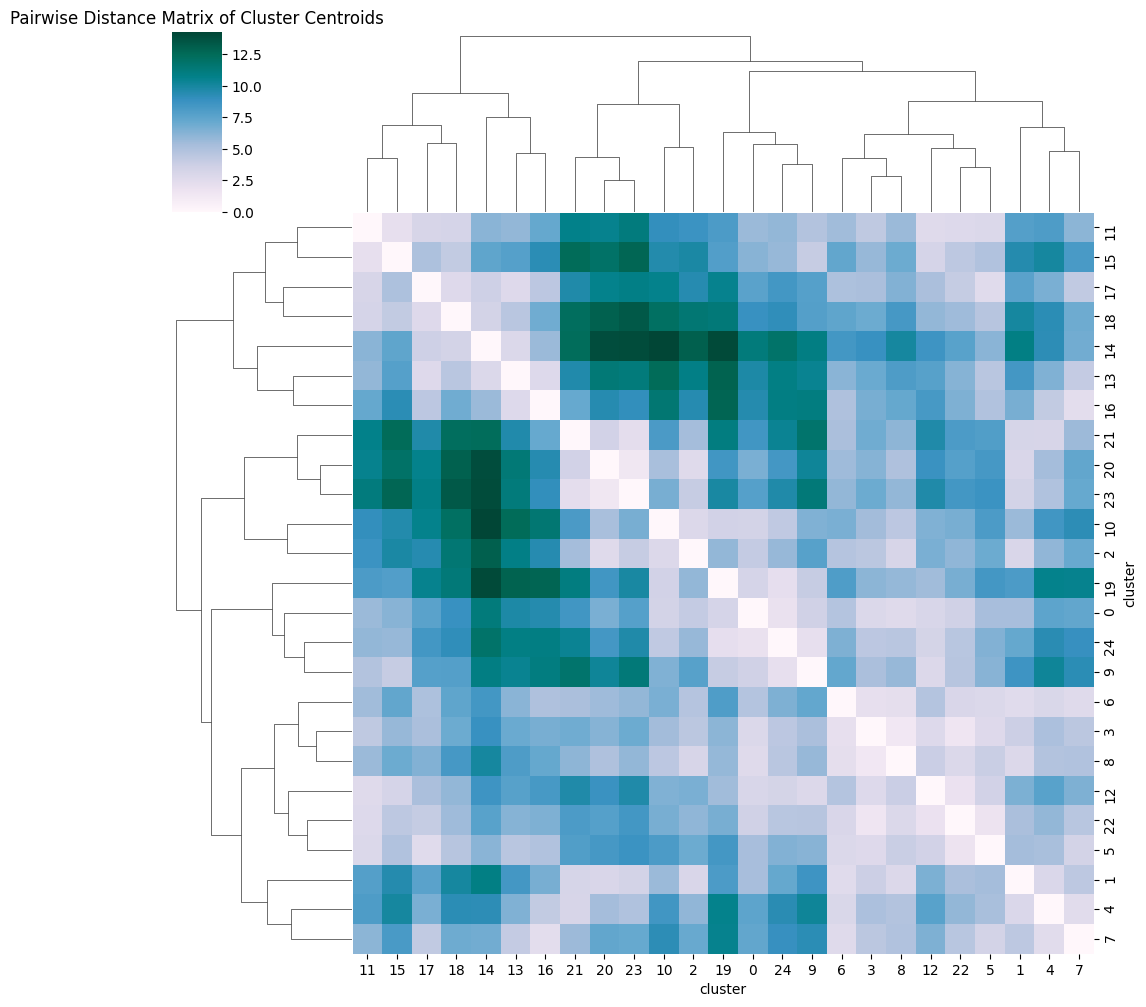

In [14]:
mde2 = tf_compute_MDE(adata_5818, spectral=True, leiden_neighbors=8)
_, _, _, _, embedding_df2 = mde2
cluster_df2 = gene_targets_per_cluster(embedding_df2)

In [17]:
cluster_df2.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,ARID2,AIRE,BHLHE41,DMRT3,ADNP2,ASCL5,ERF,AKAP8L,ASH1L,AHR,...,ATOH1,ARID3A,AKAP8,ARX,ASCL2,ANKZF1,BACH2,CREM,CREBL2,CEBPE
1,ARNT,ATOH7,ESRRA,FOXD4,ATF6B,BHLHA15,ERG,CAMTA2,BCL6B,ATMIN,...,CENPB,CREB5,BARHL1,CTCFL,FOXH1,FOXI2,FOXO1,ESR2,GATAD2B,CSRNP2
2,BHLHA9,CEBPB,FOXM1,FOXE3,DEAF1,DMRTA2,FOSB,CBX2,DLX6,CHAMP1,...,CENPS,GPBP1,GATA2,EHF,MTERF3,FOXJ1,HHEX,GATA3,MSANTD4,ZBTB6
3,CC2D1A,DMBX1,FOXN4,GATA1,DMRTC2,EBF3,GATAD2A,CREB3L4,EPAS1,DLX4,...,DR1,GRHL2,HSF2,ESX1,MTERF4,POU3F3,RARB,NKX6-2,PAX9,ZBTB21
4,CCDC17,ELF3,GBX1,HDX,ELK1,FOXA1,HNF1B,DACH2,FOXK2,DNMT1,...,DRAP1,HIC1,NFIB,FOSL1,NFE2L3,PPARA,SP2,NR1I3,ZNF12,ZFP1


In [18]:
print(cluster_df1.equals(cluster_df2))

True


### Duplicates

Warning message:

May 01 02:29:57 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.

May 01 02:29:57 PM: The following items have duplicates [ 96 149 611]

In [49]:
def find_mean_profile_duplicates(adata):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices
    mean_profiles = [compute_mean_normalized_profile(adata, indices) for indices in gene_target_groups.values()]
    for i, mp1 in enumerate(mean_profiles):
        for j, mp2 in enumerate(mean_profiles):
            if all(mp1 == mp2) and i != j:
                print(f"Mean profile {i} == {j}")
    return mean_profiles

In [50]:
test_mean_profile_list = find_mean_profile_duplicates(adata_5818)

The mean profile matrix does not contain duplicates

In [42]:
def test_spectral_duplicates(adata):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices
    mean_profiles = [compute_mean_normalized_profile(adata, indices) for indices in gene_target_groups.values()]
    mean_profiles_array = np.array(mean_profiles)
    spectral_embedding = SpectralEmbedding(
        n_components=30,
        affinity='nearest_neighbors',
        n_neighbors=10,
        eigen_solver='arpack',
        random_state=42
    )
    initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)

    pymde.seed(42)
    mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
    embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)

In [ ]:
test_spectral_duplicates(adata_5818)

May 01 02:29:57 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
May 01 02:29:57 PM: The following items have duplicates [ 96 149 611]
May 01 02:29:57 PM: Fitting a centered embedding into R^2, for a graph with 652 items and 133179 edges.
May 01 02:29:57 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
May 01 02:29:57 PM: iteration 0000 | distortion 0.805415 | residual norm 3.04748 | step length 0.132789 | percent change 1.12063
May 01 02:29:59 PM: iteration 0100 | distortion 0.136475 | residual norm 0.000117066 | step length 1 | percent change 0.525486
May 01 02:30:00 PM: iteration 0200 | distortion 0.134152 | residual norm 7.32571e-05 | step length 1 | percent change 0.191992
May 01 02:30:01 PM: iteration 0300 | distortion 0.133623 | residual norm 3.656e-05 | step length 1 | percent change 0.189789
May 01 02:30:03 PM: iteration 0400 | distortion 0.133436 | residual norm 2.65137e-05 | step len

Check if the spectral embedding contains the duplicates

In [44]:
def spectral_embedding(adata):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices
    mean_profiles = [compute_mean_normalized_profile(adata, indices) for indices in gene_target_groups.values()]
    mean_profiles_array = np.array(mean_profiles)
    spectral_embedding = SpectralEmbedding(
        n_components=30,
        affinity='nearest_neighbors',
        n_neighbors=10,
        eigen_solver='arpack',
        random_state=42
    )
    return spectral_embedding.fit_transform(mean_profiles_array)

In [46]:
test_spectral_embedding = spectral_embedding(adata_5818)

In [47]:
test_spectral_embedding

array([[-0.0041822 , -0.00475564,  0.00282675, ..., -0.00916702,
        -0.00920123,  0.01058402],
       [-0.00418639, -0.00444136,  0.00050153, ...,  0.008785  ,
         0.01413671,  0.01447387],
       [-0.00359232, -0.00353384,  0.0010234 , ..., -0.00702044,
        -0.04077588, -0.00887359],
       ...,
       [-0.00388343, -0.0029701 ,  0.00056496, ...,  0.0022664 ,
        -0.01094156,  0.00525768],
       [-0.00414721, -0.00408034,  0.00286265, ..., -0.02117646,
         0.00143694, -0.01430571],
       [-0.00172642,  0.01811078, -0.03169254, ...,  0.03645882,
        -0.00156736, -0.01575662]])

In [48]:
len(test_spectral_embedding)

652

In [53]:
test_spectral_embedding[0]

array([-0.0041822 , -0.00475564,  0.00282675,  0.00054448,  0.00672097,
        0.00275401,  0.00013898,  0.00484187,  0.00129117, -0.00274159,
        0.00416669,  0.01380668, -0.00636885, -0.00208046, -0.00448663,
       -0.00129874, -0.00817083, -0.0049238 , -0.00159679,  0.01113645,
       -0.0164668 , -0.00185916,  0.00367903, -0.01629806,  0.00157196,
        0.00620767, -0.01002407, -0.00916702, -0.00920123,  0.01058402])

In [51]:
def find_spectral_embedding_duplicates(adata):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices
    mean_profiles = [compute_mean_normalized_profile(adata, indices) for indices in gene_target_groups.values()]
    mean_profiles_array = np.array(mean_profiles)
    spectral_embedding = SpectralEmbedding(
        n_components=30,
        affinity='nearest_neighbors',
        n_neighbors=10,
        eigen_solver='arpack',
        random_state=42
    )
    spec_embedding = spectral_embedding.fit_transform(mean_profiles_array)
    for i in range(len(spec_embedding)):
        row_i = spec_embedding[i]
        for j in range(len(spec_embedding)):
            row_j = spec_embedding[j]
            if all(row_i == row_j) and i != j:
                print(f"Row {i} == {j}")

In [52]:
find_spectral_embedding_duplicates(adata_5818)

The spectral embedding does not seem to contain the duplicates, so likely these duplicates are created by pymde.preserve_neighbors()

# Differential expression analysis (DEA) on TF KO and NTC cells

## Generate small test dataset

In [19]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

# Function to filter TF KO and NTC cells
def filter_tf_ko_and_ntc(adata):
    return adata[(adata.obs["gene_target"].isin(tfs)) | (adata.obs["gene_target"] == "NTC")].copy()

def pre_DE_analysis(adata):
    """
    Prepare dataset for differential expression analysis using PyDESeq2.
    """
    # Filter TF KO and NTC cells
    adata = filter_tf_ko_and_ntc(adata)
    # Reset adata.X to raw counts
    adata.X = adata.layers["counts"].copy()
    return adata

In [20]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_alpha = pre_DE_analysis(adata_alpha)

In [21]:
test_adata = adata_alpha[(adata_alpha.obs["gene_target"] == "POU5F1") | 
                         (adata_alpha.obs["gene_target"] == "NANOG") | 
                         (adata_alpha.obs["gene_target"] == "NTC")].copy()
print(test_adata.obs["gene_target"].unique().tolist())

['NTC', 'POU5F1', 'NANOG']


In [22]:
test_adata.write("/home/ranwyl/data_tf_project/dea_test_dataset.h5ad")

In [23]:
del adata_alpha
gc.collect()

2223

## Initial testing

We will read in data from batch "ALPHA", filter the TF KO and NTC cells, and test out DEA functions on one gene target.

In [3]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

# Function to filter TF KO and NTC cells
def filter_tf_ko_and_ntc(adata):
    return adata[(adata.obs["gene_target"].isin(tfs)) | (adata.obs["gene_target"] == "NTC")].copy()

In [3]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
# Filter TF KO and NTC
adata_alpha = filter_tf_ko_and_ntc(adata_alpha)
# Reset adata.X to raw counts
adata_alpha.X = adata_alpha.layers["counts"].copy()

In [4]:
all_gene_targets = adata_alpha.obs["gene_target"].unique().tolist()
print("POU5F1" in all_gene_targets)
print("NANOG" in all_gene_targets)
print("NTC" in all_gene_targets)

True
True
True


In [4]:
test_adata = adata_alpha[(adata_alpha.obs["gene_target"] == "POU5F1") | 
                         (adata_alpha.obs["gene_target"] == "NANOG") | 
                         (adata_alpha.obs["gene_target"] == "NTC")].copy()
print(test_adata.obs["gene_target"].unique().tolist())

['NTC', 'POU5F1', 'NANOG']


In [5]:
del adata_alpha
gc.collect()

7041

First, we want to confirm that it is necessary to manually set the reference to "NTC" for DEA with PyDESeq2, since the default is to use the alphabetically first condition as the control. 
-  For example, when running DEA with POU5F1 and NTC, the default settings would choose control condition = NTC and experimental condition = POU5F1, which is correct.
-  But for NANOG and NTC, the default settings would choose control condition = NANOG and experimental condition = NTC, which is incorrect. 

So we need to set the reference to NTC.

In [53]:
def no_ref_test_pb_replicates_for_de(adata, gene_target, ntc_cells, n_replicates=3, sample_fraction=0.85, layer=None):
    """
    Generate pseudo-bulk replicates for a given gene target and matched NTC cells. 
    Modified with random seed for DEA code testing. Did not manually set reference for DEA.
    """
    np.random.seed(42)
    data_matrix = adata.layers[layer] if layer else adata.X
    target_indices = np.where(adata.obs['gene_target'] == gene_target)[0]
    n_target = len(target_indices)
    target_bulk = []
    ntc_bulk = []
    sample_names = []
    control_names = []

    for i in range(n_replicates):
        # Sample from gene_target
        sampled_target_indices = np.random.choice(target_indices, int(n_target * sample_fraction), replace=False)
        target_profile = data_matrix[sampled_target_indices].sum(axis=0)
        target_bulk.append(target_profile)
        sample_names.append(f"{gene_target}_rep_{i+1}")

        # Sample from NTC
        sampled_ntc_indices = np.random.choice(ntc_cells, int(n_target * sample_fraction), replace=False)
        ntc_profile = data_matrix[sampled_ntc_indices].sum(axis=0)
        ntc_bulk.append(ntc_profile)
        control_names.append(f"NTC_rep_{i+1}")
    
    # Convert to DataFrame
    sample_names.extend(control_names)
    # Build counts DataFrame
    pseudo_bulk_df = pd.DataFrame(np.vstack(target_bulk + ntc_bulk), index=sample_names, columns=adata.var_names)
    pseudo_bulk_df = pseudo_bulk_df[pseudo_bulk_df.columns[pseudo_bulk_df.sum(axis=0)>=1]] #Remove any samples with 0s in both NTC and Perturbed Sample
    # Build metadata DataFrame
    metadata_records = [{'condition': sample.split('_')[0]} for sample in sample_names]
    metadata_df = pd.DataFrame(metadata_records, index=sample_names)

    return pseudo_bulk_df, metadata_df

In [54]:
def ref_test_pb_replicates_for_de(adata, gene_target, ntc_cells, n_replicates=3, sample_fraction=0.85, layer=None):
    """
    Generate pseudo-bulk replicates for a given gene target and matched NTC cells. 
    Modified with random seed for DEA code testing. Manually set reference for DEA.
    """
    np.random.seed(42)
    data_matrix = adata.layers[layer] if layer else adata.X
    target_indices = np.where(adata.obs['gene_target'] == gene_target)[0]
    n_target = len(target_indices)
    target_bulk = []
    ntc_bulk = []
    sample_names = []
    control_names = []

    for i in range(n_replicates):
        # Sample from gene_target
        sampled_target_indices = np.random.choice(target_indices, int(n_target * sample_fraction), replace=False)
        target_profile = data_matrix[sampled_target_indices].sum(axis=0)
        target_bulk.append(target_profile)
        sample_names.append(f"{gene_target}_rep_{i+1}")

        # Sample from NTC
        sampled_ntc_indices = np.random.choice(ntc_cells, int(n_target * sample_fraction), replace=False)
        ntc_profile = data_matrix[sampled_ntc_indices].sum(axis=0)
        ntc_bulk.append(ntc_profile)
        control_names.append(f"NTC_rep_{i+1}")
    
    # Convert to DataFrame
    sample_names.extend(control_names)
    # Build counts DataFrame
    pseudo_bulk_df = pd.DataFrame(np.vstack(target_bulk + ntc_bulk), index=sample_names, columns=adata.var_names)
    pseudo_bulk_df = pseudo_bulk_df[pseudo_bulk_df.columns[pseudo_bulk_df.sum(axis=0)>=1]] #Remove any samples with 0s in both NTC and Perturbed Sample
    # Build metadata DataFrame
    metadata_records = [{'condition': sample.split('_')[0]} for sample in sample_names]
    metadata_df = pd.DataFrame(metadata_records, index=sample_names)
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", gene_target],
        ordered=True
        ) # Set NTC as reference

    return pseudo_bulk_df, metadata_df

In [55]:
def no_ref_test_pb(adata, gene_target):
    ntc_cells = np.where(adata.obs["gene_target"] == "NTC")[0]
    gene_targets = list(adata.obs["gene_target"].unique())
    gene_targets.remove("NTC")
    test_pb_df, test_meta_df = no_ref_test_pb_replicates_for_de(
        adata, gene_target, ntc_cells, n_replicates=3, sample_fraction=0.85, layer=None
        )
    return test_pb_df, test_meta_df

In [56]:
def ref_test_pb(adata, gene_target):
    ntc_cells = np.where(adata.obs["gene_target"] == "NTC")[0]
    gene_targets = list(adata.obs["gene_target"].unique())
    gene_targets.remove("NTC")
    test_pb_df, test_meta_df = ref_test_pb_replicates_for_de(
        adata, gene_target, ntc_cells, n_replicates=3, sample_fraction=0.85, layer=None
        )
    return test_pb_df, test_meta_df

In [57]:
oct4_pb_df, no_ref_oct4_meta_df = no_ref_test_pb(test_adata, "POU5F1")

In [58]:
oct4_pb_df.head()

,MIR1302-2HG,ENSG00000238009,ENSG00000241860,ENSG00000290385,ENSG00000291215,ENSG00000229905,LINC01409,ENSG00000290784,LINC00115,LINC01128,...,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,ENSG00000276256,ENSG00000271254,ENSG00000278817,ENSG00000277196
POU5F1_rep_1,0.0,1.0,0.0,2.0,1.0,0.0,6.0,2.0,0.0,4.0,...,702.0,27.0,1172.0,203.0,176.0,1153.0,10.0,4.0,0.0,1.0
POU5F1_rep_2,0.0,1.0,0.0,3.0,2.0,0.0,6.0,1.0,0.0,4.0,...,711.0,26.0,1178.0,198.0,180.0,1139.0,10.0,2.0,0.0,1.0
POU5F1_rep_3,0.0,1.0,0.0,2.0,2.0,0.0,4.0,2.0,0.0,3.0,...,708.0,26.0,1142.0,198.0,179.0,1123.0,9.0,4.0,0.0,1.0
NTC_rep_1,1.0,2.0,2.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,...,686.0,42.0,1273.0,259.0,210.0,1096.0,2.0,1.0,0.0,0.0
NTC_rep_2,0.0,2.0,5.0,1.0,3.0,1.0,4.0,0.0,1.0,5.0,...,680.0,50.0,1383.0,252.0,175.0,1159.0,3.0,1.0,1.0,0.0


In [59]:
display(no_ref_oct4_meta_df)

,condition
POU5F1_rep_1,POU5F1
POU5F1_rep_2,POU5F1
POU5F1_rep_3,POU5F1
NTC_rep_1,NTC
NTC_rep_2,NTC
NTC_rep_3,NTC


In [60]:
_, ref_oct4_meta_df = ref_test_pb(test_adata, "POU5F1")

In [61]:
display(ref_oct4_meta_df)

,condition
POU5F1_rep_1,POU5F1
POU5F1_rep_2,POU5F1
POU5F1_rep_3,POU5F1
NTC_rep_1,NTC
NTC_rep_2,NTC
NTC_rep_3,NTC


In [66]:
def test_dds(test_pb_df, test_meta_df, n_cpus):
    dds = DeseqDataSet(
        counts = test_pb_df, 
        metadata = test_meta_df, 
        design="~condition",
        refit_cooks=True,
        n_cpus=n_cpus
        )
    dds.deseq2()
    return dds

In [67]:
no_ref_oct4_dds = test_dds(oct4_pb_df, no_ref_oct4_meta_df, 8)

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.10 seconds.

Fitting dispersion trend curve...
... done in 0.38 seconds.

Fitting MAP dispersions...
... done in 2.35 seconds.

Fitting LFCs...
... done in 1.13 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [68]:
no_ref_oct4_dds

AnnData object with n_obs × n_vars = 6 × 21591
    obs: 'condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [71]:
no_ref_oct4_dds.varm["LFC"].head()

,Intercept,condition[T.POU5F1]
MIR1302-2HG,-0.991571,-0.761045
ENSG00000238009,0.542482,-0.601998
ENSG00000241860,1.508810,-3.261426
ENSG00000290385,0.034483,0.753677
ENSG00000291215,1.240286,-0.788246


In [72]:
ref_oct4_dds = test_dds(oct4_pb_df, ref_oct4_meta_df, 8)

Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.10 seconds.

Fitting dispersion trend curve...
... done in 0.37 seconds.

Fitting MAP dispersions...
... done in 2.15 seconds.

Fitting LFCs...
... done in 1.32 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [73]:
ref_oct4_dds.varm["LFC"].head()

,Intercept,condition[T.POU5F1]
MIR1302-2HG,-0.991571,-0.761045
ENSG00000238009,0.542482,-0.601998
ENSG00000241860,1.508810,-3.261426
ENSG00000290385,0.034483,0.753677
ENSG00000291215,1.240286,-0.788246


In [74]:
nanog_pb_df, no_ref_nanog_meta_df = no_ref_test_pb(test_adata, "NANOG")
_, ref_nanog_meta_df = ref_test_pb(test_adata, "NANOG")

In [75]:
no_ref_nanog_dds = test_dds(nanog_pb_df, no_ref_nanog_meta_df, 8)

Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.11 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 1.84 seconds.

Fitting LFCs...
... done in 1.23 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [76]:
ref_nanog_dds = test_dds(nanog_pb_df, ref_nanog_meta_df, 8)

Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.23 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 1.84 seconds.

Fitting LFCs...
... done in 1.29 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [77]:
no_ref_nanog_dds.varm["LFC"].head()

,Intercept,condition[T.NTC]
ENSG00000238009,-0.011968,-1.023357
ENSG00000241860,1.086576,0.287326
ENSG00000290385,1.086616,-0.259772
ENSG00000291215,0.681144,-0.402373
LINC01409,1.835339,-0.459484


In [78]:
ref_nanog_dds.varm["LFC"].head()

,Intercept,condition[T.NANOG]
ENSG00000238009,-1.035324,1.023356
ENSG00000241860,1.373899,-0.287323
ENSG00000290385,0.826836,0.259780
ENSG00000291215,0.278771,0.402373
LINC01409,1.375855,0.459486


These results show that manually setting the reference for PyDESeq2 is necessary. Now we want to test out code to successfully perform LFC shrinkage.

In [91]:
def test_deseq_stats_no_shrink(dds, gene_target, n_cpus):
    # Set inference to use only n_cpus CPUs
    inference = DefaultInference(n_cpus=n_cpus)
    ds = DeseqStats(
        dds, 
        contrast=["condition", gene_target, "NTC"], 
        alpha=0.05,
        inference=inference
        )
    ds.summary()
    return ds.results_df

In [92]:
nanog_dstats_no_shrink = test_deseq_stats_no_shrink(ref_nanog_dds, "NANOG", 8)

Running Wald tests...


Log2 fold change & Wald test p-value: condition NANOG vs NTC
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009     0.651190        1.476390  2.019986  0.730891  0.464846   
ENSG00000241860     3.450667       -0.414520  0.826053 -0.501808  0.615803   
ENSG00000290385     2.606595        0.374784  0.958296  0.391094  0.695728   
ENSG00000291215     1.649877        0.580501  1.189055  0.488204  0.625406   
LINC01409           5.116130        0.662898  0.682872  0.970749  0.331673   
...                      ...             ...       ...       ...       ...   
MT-CYB           1004.811247       -0.253666  0.067067 -3.782260  0.000155   
ENSG00000276256     4.305649       -0.452647  0.736975 -0.614196  0.539086   
ENSG00000271254     1.655420       -0.012447  1.176339 -0.010581  0.991558   
ENSG00000278817     0.494173        2.438244  2.549724  0.956278  0.338932   
ENSG00000277196     0.487499       -2.431558  2.618337 -0.928665  0.353063   

  

... done in 1.84 seconds.



In [93]:
def test_deseq_stats_summary_shrink_summary(dds, gene_target, n_cpus):
    # Set inference to use only n_cpus CPUs
    inference = DefaultInference(n_cpus=n_cpus)
    ds = DeseqStats(
        dds, 
        contrast=["condition", gene_target, "NTC"], 
        alpha=0.05,
        inference=inference
        )
    ds.summary()
    ds.lfc_shrink(coeff=f"condition[T.{gene_target}]")
    ds.summary()
    return ds.results_df

In [94]:
nanog_dstats_summary_shrink_summary = \
    test_deseq_stats_summary_shrink_summary(ref_nanog_dds, "NANOG", 8)

Running Wald tests...
... done in 0.77 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition NANOG vs NTC
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009     0.651190        1.476390  2.019986  0.730891  0.464846   
ENSG00000241860     3.450667       -0.414520  0.826053 -0.501808  0.615803   
ENSG00000290385     2.606595        0.374784  0.958296  0.391094  0.695728   
ENSG00000291215     1.649877        0.580501  1.189055  0.488204  0.625406   
LINC01409           5.116130        0.662898  0.682872  0.970749  0.331673   
...                      ...             ...       ...       ...       ...   
MT-CYB           1004.811247       -0.253666  0.067067 -3.782260  0.000155   
ENSG00000276256     4.305649       -0.452647  0.736975 -0.614196  0.539086   
ENSG00000271254     1.655420       -0.012447  1.176339 -0.010581  0.991558   
ENSG00000278817     0.494173        2.438244  2.549724  0.956278  0.338932   
ENSG00000277196     0.487499       -2.431558  2.618337 -0.928665  0.353063   

  

... done in 2.39 seconds.



In [ ]:
def test_deseq_stats_summary_shrink(dds, gene_target, n_cpus):
    # Set inference to use only n_cpus CPUs
    inference = DefaultInference(n_cpus=n_cpus)
    ds = DeseqStats(
        dds, 
        contrast=["condition", gene_target, "NTC"], 
        alpha=0.05,
        inference=inference
        )
    ds.summary()
    ds.lfc_shrink(coeff=f"condition[T.{gene_target}]")
    stat_res = ds.results_df
    return ds, stat_res

In [104]:
nanog_ds_summary_shrink, nanog_ds_df_summary_shrink = \
    test_deseq_stats_summary_shrink(ref_nanog_dds, "NANOG", 8)

Running Wald tests...
... done in 0.75 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition NANOG vs NTC
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009     0.651190        1.476390  2.019986  0.730891  0.464846   
ENSG00000241860     3.450667       -0.414520  0.826053 -0.501808  0.615803   
ENSG00000290385     2.606595        0.374784  0.958296  0.391094  0.695728   
ENSG00000291215     1.649877        0.580501  1.189055  0.488204  0.625406   
LINC01409           5.116130        0.662898  0.682872  0.970749  0.331673   
...                      ...             ...       ...       ...       ...   
MT-CYB           1004.811247       -0.253666  0.067067 -3.782260  0.000155   
ENSG00000276256     4.305649       -0.452647  0.736975 -0.614196  0.539086   
ENSG00000271254     1.655420       -0.012447  1.176339 -0.010581  0.991558   
ENSG00000278817     0.494173        2.438244  2.549724  0.956278  0.338932   
ENSG00000277196     0.487499       -2.431558  2.618337 -0.928665  0.353063   

  

... done in 2.37 seconds.



In [105]:
nanog_ds_summary_shrink.shrunk_LFCs

True

In [106]:
def test_deseq_stats_summary_shrink_summary(dds, gene_target, n_cpus):
    # Set inference to use only n_cpus CPUs
    inference = DefaultInference(n_cpus=n_cpus)
    ds = DeseqStats(
        dds, 
        contrast=["condition", gene_target, "NTC"], 
        alpha=0.05,
        inference=inference
        )
    ds.summary()
    ds.lfc_shrink(coeff=f"condition[T.{gene_target}]")
    ds.summary()
    stat_res = ds.results_df
    return ds, stat_res

In [107]:
nanog_ds_summary_shrink_summary, nanog_ds_df_summary_shrink_summary = \
    test_deseq_stats_summary_shrink_summary(ref_nanog_dds, "NANOG", 8)

Running Wald tests...
... done in 0.76 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition NANOG vs NTC
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009     0.651190        1.476390  2.019986  0.730891  0.464846   
ENSG00000241860     3.450667       -0.414520  0.826053 -0.501808  0.615803   
ENSG00000290385     2.606595        0.374784  0.958296  0.391094  0.695728   
ENSG00000291215     1.649877        0.580501  1.189055  0.488204  0.625406   
LINC01409           5.116130        0.662898  0.682872  0.970749  0.331673   
...                      ...             ...       ...       ...       ...   
MT-CYB           1004.811247       -0.253666  0.067067 -3.782260  0.000155   
ENSG00000276256     4.305649       -0.452647  0.736975 -0.614196  0.539086   
ENSG00000271254     1.655420       -0.012447  1.176339 -0.010581  0.991558   
ENSG00000278817     0.494173        2.438244  2.549724  0.956278  0.338932   
ENSG00000277196     0.487499       -2.431558  2.618337 -0.928665  0.353063   

  

... done in 2.37 seconds.



In [108]:
nanog_ds_summary_shrink_summary.shrunk_LFCs

True

In [109]:
nanog_ds_df_summary_shrink.equals(nanog_ds_df_summary_shrink_summary)

True

For successful LFC shrinkage, `DeseqStats.summary()` must be run before `DeseqStats.lfc_shrink` but does not need to be run again after LFC shrinkage.

## DEA: goals/issues, code changes, and final functions

To summarize my changes to the differential expression analysis code and my goals for making these changes:

These were the issues I was facing:
-  Issue: To use the DEA results for pre-ranked GSEA, I needed DEA to be run with LFC shrinkage and to report all results, not just DEGs with p-adj > 0.05, so I needed to modify the Mali lab code
-  Issue: Certain `PyDESeq2` arguments were deprecated, even after downgrading to version 0.5.0 on Yesh's recommendation, so some code needed to be modified for this reason as well

These were the changes I made and the new functions I defined:
-  Function `tf_pseudo_bulk_replicates_for_de`
    -  PyDESeq2 now uses the alphabetically first condition as the reference, but we want "NTC" to be the reference, so I modified the Mali lab's function `generate_pseudo_bulk_replicates_for_de` to use `pandas.Categorical` to manually set the reference to "NTC"
-  Function `tf_deseq2`: 
    -  Changed `DeseqDataSet` function calls to remove deprecated arguments `design_factors` and `ref_level`, and replace with `design="~condition"`, which works because of the changes I made to the pseudobulk function
    -  Created a `DefaultInference` to control the number of CPUs used for `DeseqDataSet` and `DeseqStats` functions, with a default value of 8 CPUs
    -  Added LFC shrinkage
- Function `tf_run_deseq2_analysis`
    -  Added `n_cpus` argument to control number of CPUs used for parallelization and `PyDESeq2` functions, with a default value of 8 CPUs
    -  Changed `tf_deseq2` function calls to reflect my changes
-  Import statements
    -  Need to add an import statement for `PyDESeq2` default inference

The last task is to modify the Mali lab's `save_DEG_df` function to save all DE results, not just DEGs with LFC > 0.05.

In [6]:
def tf_pseudo_bulk_replicates_for_de(adata, gene_target, ntc_cells, n_replicates=3, sample_fraction=0.85, layer=None):
    """
    Generate pseudo-bulk replicates for a given gene target and matched NTC cells. 
    Modified to manually set reference for DEA.
    """
    data_matrix = adata.layers[layer] if layer else adata.X
    target_indices = np.where(adata.obs['gene_target'] == gene_target)[0]
    n_target = len(target_indices)
    target_bulk = []
    ntc_bulk = []
    sample_names = []
    control_names = []

    for i in range(n_replicates):
        # Sample from gene_target
        sampled_target_indices = np.random.choice(target_indices, int(n_target * sample_fraction), replace=False)
        target_profile = data_matrix[sampled_target_indices].sum(axis=0)
        target_bulk.append(target_profile)
        sample_names.append(f"{gene_target}_rep_{i+1}")

        # Sample from NTC
        sampled_ntc_indices = np.random.choice(ntc_cells, int(n_target * sample_fraction), replace=False)
        ntc_profile = data_matrix[sampled_ntc_indices].sum(axis=0)
        ntc_bulk.append(ntc_profile)
        control_names.append(f"NTC_rep_{i+1}")
    
    # Convert to DataFrame
    sample_names.extend(control_names)
    # Build counts DataFrame
    pseudo_bulk_df = pd.DataFrame(np.vstack(target_bulk + ntc_bulk), index=sample_names, columns=adata.var_names)
    pseudo_bulk_df = pseudo_bulk_df[pseudo_bulk_df.columns[pseudo_bulk_df.sum(axis=0)>=1]] #Remove any samples with 0s in both NTC and Perturbed Sample
    # Build metadata DataFrame
    metadata_records = [{'condition': sample.split('_')[0]} for sample in sample_names]
    metadata_df = pd.DataFrame(metadata_records, index=sample_names)
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", gene_target],
        ordered=True
        ) # Set NTC as reference

    return pseudo_bulk_df, metadata_df

def tf_deseq2(data, metadata, contrast, alpha=0.05, n_cpus=8):
    inference = DefaultInference(n_cpus=n_cpus) # Only use n_cpus CPUs
    
    dds = DeseqDataSet(
        counts = data, 
        metadata = metadata, 
        design="~condition",
        refit_cooks=True,
        inference=inference,
        quiet=True
        )
    dds.deseq2()

    stat_res = DeseqStats(
        dds, 
        contrast=contrast, 
        alpha=alpha,
        inference=inference,
        quiet=True)
    stat_res.summary()
    stat_res.lfc_shrink(coeff=f"condition[T.{contrast[1]}]") # Shrink LFCs of gene_target samples
    results = stat_res.results_df
    return results

def tf_run_deseq2_analysis(adata, n_cpus=8, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", 
                                      n_replicates=3, sample_fraction=0.85, layer=None, alpha=0.05):
    ntc_cells = np.where(adata.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group

    def process_gene_target(gene_target):
        pseudo_bulk_df, metadata_df = tf_pseudo_bulk_replicates_for_de(
            adata, gene_target, ntc_cells, n_replicates=n_replicates, 
            sample_fraction=sample_fraction, layer=layer
        )
        return tf_deseq2(
            pseudo_bulk_df, 
            metadata_df, 
            contrast=["condition", gene_target, ntc_cells_delimiter], 
            alpha=alpha,
            n_cpus=n_cpus)

    with tqdm_joblib(desc="Running DE analysis", total=len(gene_targets)):
        results = Parallel(n_jobs=n_cpus)(delayed(process_gene_target)(gene_target) for gene_target in gene_targets)
    
    results_dict = dict(zip(gene_targets, results))
    
    return results_dict

We will run the above code to generate the DE results for the NTC, NANOG, and POU5F1 test dataset.

In [7]:
test_results_dict = tf_run_deseq2_analysis(test_adata, n_cpus=16)

Running DE analysis:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
test_results_dict.keys()

dict_keys(['POU5F1', 'NANOG'])

In [12]:
test_results_dict["POU5F1"]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
MIR1302-2HG,0.161017,-0.035095,0.544599,-0.252089,0.800972,NaN
ENSG00000238009,0.994785,-0.006334,0.616787,-0.044568,0.964452,NaN
ENSG00000241860,1.842197,-3.403006,2.412232,-2.066250,0.038805,NaN
ENSG00000290385,2.161228,-0.052779,0.560708,-0.283470,0.776816,NaN
ENSG00000291215,2.640823,-0.179084,0.563088,-0.856861,0.391522,0.612712
...,...,...,...,...,...,...
MT-CYB,1119.048347,-0.175842,0.050003,-3.544874,0.000393,0.004068
ENSG00000276256,7.046731,0.341895,0.484423,1.264168,0.206170,0.416544
ENSG00000271254,2.315268,0.066907,0.576413,0.349993,0.726344,NaN
ENSG00000278817,0.336407,-0.066712,0.542478,-0.586553,0.557504,NaN


In [13]:
test_results_dict["NANOG"]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000238009,0.489707,0.030358,0.400618,0.966562,3.337629e-01,NaN
ENSG00000241860,3.808635,-0.098269,0.308029,-1.525109,1.272318e-01,NaN
ENSG00000290385,2.974809,-0.021597,0.289424,-0.406027,6.847229e-01,NaN
ENSG00000291215,2.137117,-0.031391,0.290609,-0.680224,4.963626e-01,NaN
LINC01409,5.090394,0.066704,0.308931,0.961660,3.362205e-01,7.091795e-01
...,...,...,...,...,...,...
MT-CYB,1022.975350,-0.458591,0.063799,-7.396249,1.400852e-13,4.388151e-11
ENSG00000276256,2.797463,0.028473,0.306964,0.546574,5.846711e-01,NaN
ENSG00000271254,1.478040,0.030562,0.325735,0.778020,4.365574e-01,NaN
ENSG00000278817,0.820671,0.009635,0.319366,0.335138,7.375209e-01,NaN


Now we want to edit the code to save the DE results.

In [15]:
test_col_names = {col: f"NANOG_{col}" for col in test_results_dict["NANOG"]}
print(test_col_names)

{'baseMean': 'NANOG_baseMean', 'log2FoldChange': 'NANOG_log2FoldChange', 'lfcSE': 'NANOG_lfcSE', 'stat': 'NANOG_stat', 'pvalue': 'NANOG_pvalue', 'padj': 'NANOG_padj'}


In [25]:
def test_tf_save_DE_df(results_dict):
    df_list = list()
    for gene_target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend TF KO name to each column label
        new_col_names = {col: f"{gene_target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df, df_list

In [26]:
test_de_df, test_df_list = test_tf_save_DE_df(test_results_dict)

In [27]:
test_df_list[0]

,POU5F1_baseMean,POU5F1_log2FoldChange,POU5F1_lfcSE,POU5F1_stat,POU5F1_pvalue,POU5F1_padj
A1BG,7.108182,-0.176555,0.439466,-0.717545,0.473038,0.682369
A1BG-AS1,0.652113,-0.092032,0.602493,-0.750488,0.452961,NaN
A2M,0.518129,-0.129962,0.576665,-0.961540,0.336281,NaN
A2M-AS1,1.163416,-0.051351,0.600859,-0.345042,0.730063,NaN
A2ML1,2.669143,-0.187440,0.562940,-0.883799,0.376805,0.600377
...,...,...,...,...,...,...
ZYG11A,2.608726,-0.009860,0.544044,-0.051114,0.959235,NaN
ZYG11B,27.097113,0.326751,0.269375,1.487585,0.136860,0.323909
ZYX,23.987625,-0.763542,0.301587,-2.972814,0.002951,0.020872
ZZEF1,6.745809,0.065580,0.434938,0.273326,0.784603,0.900918


In [28]:
test_df_list[1]

,NANOG_baseMean,NANOG_log2FoldChange,NANOG_lfcSE,NANOG_stat,NANOG_pvalue,NANOG_padj
A1BG,5.119138,-0.182909,0.387781,-2.135749,0.032700,0.236208
A1BG-AS1,1.491392,0.009109,0.308983,0.236971,0.812679,NaN
A2M-AS1,0.655189,0.020340,0.343048,0.737603,0.460756,NaN
A2ML1,3.455651,-0.072912,0.295645,-1.232194,0.217877,NaN
A2ML1-AS1,10.222468,0.046754,0.269495,0.539944,0.589236,0.856372
...,...,...,...,...,...,...
ZYG11A,1.315754,-0.021439,0.292457,-0.580639,0.561484,NaN
ZYG11B,22.018945,0.048781,0.228166,0.463909,0.642713,0.881280
ZYX,25.567304,0.140096,0.249788,1.190332,0.233916,0.610401
ZZEF1,7.559002,-0.038549,0.271689,-0.499862,0.617172,0.871371


In [29]:
test_de_df

,POU5F1_baseMean,POU5F1_log2FoldChange,POU5F1_lfcSE,POU5F1_stat,POU5F1_pvalue,POU5F1_padj,NANOG_baseMean,NANOG_log2FoldChange,NANOG_lfcSE,NANOG_stat,NANOG_pvalue,NANOG_padj
A1BG,7.108182,-0.176555,0.439466,-0.717545,0.473038,0.682369,5.119138,-0.182909,0.387781,-2.135749,0.032700,0.236208
A1BG-AS1,0.652113,-0.092032,0.602493,-0.750488,0.452961,NaN,1.491392,0.009109,0.308983,0.236971,0.812679,NaN
A2M,0.518129,-0.129962,0.576665,-0.961540,0.336281,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M-AS1,1.163416,-0.051351,0.600859,-0.345042,0.730063,NaN,0.655189,0.020340,0.343048,0.737603,0.460756,NaN
A2ML1,2.669143,-0.187440,0.562940,-0.883799,0.376805,0.600377,3.455651,-0.072912,0.295645,-1.232194,0.217877,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,2.608726,-0.009860,0.544044,-0.051114,0.959235,NaN,1.315754,-0.021439,0.292457,-0.580639,0.561484,NaN
ZYG11B,27.097113,0.326751,0.269375,1.487585,0.136860,0.323909,22.018945,0.048781,0.228166,0.463909,0.642713,0.881280
ZYX,23.987625,-0.763542,0.301587,-2.972814,0.002951,0.020872,25.567304,0.140096,0.249788,1.190332,0.233916,0.610401
ZZEF1,6.745809,0.065580,0.434938,0.273326,0.784603,0.900918,7.559002,-0.038549,0.271689,-0.499862,0.617172,0.871371


In [30]:
def tf_save_DE_df(results_dict):
    df_list = list()
    for gene_target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend TF KO name to each column label
        new_col_names = {col: f"{gene_target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [31]:
test_df = tf_save_DE_df(test_results_dict)
test_df

,POU5F1_baseMean,POU5F1_log2FoldChange,POU5F1_lfcSE,POU5F1_stat,POU5F1_pvalue,POU5F1_padj,NANOG_baseMean,NANOG_log2FoldChange,NANOG_lfcSE,NANOG_stat,NANOG_pvalue,NANOG_padj
A1BG,7.108182,-0.176555,0.439466,-0.717545,0.473038,0.682369,5.119138,-0.182909,0.387781,-2.135749,0.032700,0.236208
A1BG-AS1,0.652113,-0.092032,0.602493,-0.750488,0.452961,NaN,1.491392,0.009109,0.308983,0.236971,0.812679,NaN
A2M,0.518129,-0.129962,0.576665,-0.961540,0.336281,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M-AS1,1.163416,-0.051351,0.600859,-0.345042,0.730063,NaN,0.655189,0.020340,0.343048,0.737603,0.460756,NaN
A2ML1,2.669143,-0.187440,0.562940,-0.883799,0.376805,0.600377,3.455651,-0.072912,0.295645,-1.232194,0.217877,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,2.608726,-0.009860,0.544044,-0.051114,0.959235,NaN,1.315754,-0.021439,0.292457,-0.580639,0.561484,NaN
ZYG11B,27.097113,0.326751,0.269375,1.487585,0.136860,0.323909,22.018945,0.048781,0.228166,0.463909,0.642713,0.881280
ZYX,23.987625,-0.763542,0.301587,-2.972814,0.002951,0.020872,25.567304,0.140096,0.249788,1.190332,0.233916,0.610401
ZZEF1,6.745809,0.065580,0.434938,0.273326,0.784603,0.900918,7.559002,-0.038549,0.271689,-0.499862,0.617172,0.871371


## Old code: run DEA with lfc_shrink(adapt=True)

Run DEA on "ALPHA" batch dataset with pseudobulk sample fraction of 85%. The ALPHA batch has 643 unique TF KOs.

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")

In [ ]:
adata_alpha = pre_DE_analysis(adata_alpha)

In [ ]:
results_dict_alpha = tf_run_deseq2_analysis(adata_alpha, n_cpus=16)

Running DE analysis:   0%|          | 0/643 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1087: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1087: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1087: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * n

354 RuntimeWarning messages - saved output as "ALPHA_DEA_warnings.txt"

In [ ]:
alpha_DE_df = tf_save_DE_df(results_dict_alpha)

In [ ]:
alpha_DE_df

,DMRT2_baseMean,DMRT2_log2FoldChange,DMRT2_lfcSE,DMRT2_stat,DMRT2_pvalue,DMRT2_padj,OSR2_baseMean,OSR2_log2FoldChange,OSR2_lfcSE,OSR2_stat,...,ZNF843_lfcSE,ZNF843_stat,ZNF843_pvalue,ZNF843_padj,NHLH1_baseMean,NHLH1_log2FoldChange,NHLH1_lfcSE,NHLH1_stat,NHLH1_pvalue,NHLH1_padj
A1BG,6.875364,-0.001327,0.154457,-0.063558,0.949322,NaN,3.473287,-0.022232,0.174468,-1.041679,...,0.184616,-0.214692,0.830008,NaN,0.704544,-0.013934,0.146809,-1.345436,0.178484,0.928049
A1BG-AS1,1.101701,0.012474,0.186827,1.332691,0.182633,NaN,0.487322,0.003091,0.193898,0.366516,...,NaN,NaN,NaN,NaN,0.301210,0.004454,0.234449,0.541465,0.588187,0.928049
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.344469,-0.005415,0.137582,-0.712531,0.476136,0.928049
A2M,0.351822,-0.005334,0.133526,-0.731454,0.464502,NaN,0.644225,0.006998,0.198612,0.720151,...,0.153373,-0.248865,0.803466,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M-AS1,0.822318,0.001895,0.164840,0.246827,0.805042,NaN,0.794347,0.016912,0.233095,1.346631,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,16.045105,0.010129,0.149416,0.323526,0.746297,NaN,10.452822,0.020087,0.174225,0.584365,...,0.182141,0.310944,0.755844,NaN,7.222228,0.032527,0.175388,1.199752,0.230236,0.928049
ZYX,23.754059,0.000494,0.142753,0.012273,0.990208,NaN,14.938261,0.116284,0.255289,2.144555,...,0.189636,0.823104,0.410449,NaN,7.210094,-0.011740,0.161423,-0.460063,0.645471,0.928049
ZZEF1,4.040848,0.013773,0.166879,0.846684,0.397171,NaN,7.475842,0.042421,0.196517,1.429903,...,0.179428,-1.357322,0.174679,NaN,2.248497,0.010143,0.173831,0.663402,0.507073,0.928049
ZZZ3,26.837591,0.005413,0.140693,0.141175,0.887732,NaN,18.015645,-0.123108,0.243049,-2.100738,...,0.175937,-0.533989,0.593349,NaN,14.027135,0.002600,0.155665,0.075739,0.939627,0.969098


Use pickle package to save DE results with 85% sample fraction as .pkl file for faster I/O, and read back in

In [ ]:
alpha_filepath_pkl = "/home/ranwyl/results_tf_project/ALPHA_DEGs_85.pkl"
alpha_DE_df.to_pickle(alpha_filepath_pkl)

In [ ]:
alpha_DE_df = pd.read_pickle(alpha_filepath_pkl)

In [ ]:
alpha_DE_df

,DMRT2_baseMean,DMRT2_log2FoldChange,DMRT2_lfcSE,DMRT2_stat,DMRT2_pvalue,DMRT2_padj,OSR2_baseMean,OSR2_log2FoldChange,OSR2_lfcSE,OSR2_stat,...,ZNF843_lfcSE,ZNF843_stat,ZNF843_pvalue,ZNF843_padj,NHLH1_baseMean,NHLH1_log2FoldChange,NHLH1_lfcSE,NHLH1_stat,NHLH1_pvalue,NHLH1_padj
A1BG,6.875364,-0.001327,0.154457,-0.063558,0.949322,NaN,3.473287,-0.022232,0.174468,-1.041679,...,0.184616,-0.214692,0.830008,NaN,0.704544,-0.013934,0.146809,-1.345436,0.178484,0.928049
A1BG-AS1,1.101701,0.012474,0.186827,1.332691,0.182633,NaN,0.487322,0.003091,0.193898,0.366516,...,NaN,NaN,NaN,NaN,0.301210,0.004454,0.234449,0.541465,0.588187,0.928049
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.344469,-0.005415,0.137582,-0.712531,0.476136,0.928049
A2M,0.351822,-0.005334,0.133526,-0.731454,0.464502,NaN,0.644225,0.006998,0.198612,0.720151,...,0.153373,-0.248865,0.803466,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M-AS1,0.822318,0.001895,0.164840,0.246827,0.805042,NaN,0.794347,0.016912,0.233095,1.346631,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,16.045105,0.010129,0.149416,0.323526,0.746297,NaN,10.452822,0.020087,0.174225,0.584365,...,0.182141,0.310944,0.755844,NaN,7.222228,0.032527,0.175388,1.199752,0.230236,0.928049
ZYX,23.754059,0.000494,0.142753,0.012273,0.990208,NaN,14.938261,0.116284,0.255289,2.144555,...,0.189636,0.823104,0.410449,NaN,7.210094,-0.011740,0.161423,-0.460063,0.645471,0.928049
ZZEF1,4.040848,0.013773,0.166879,0.846684,0.397171,NaN,7.475842,0.042421,0.196517,1.429903,...,0.179428,-1.357322,0.174679,NaN,2.248497,0.010143,0.173831,0.663402,0.507073,0.928049
ZZZ3,26.837591,0.005413,0.140693,0.141175,0.887732,NaN,18.015645,-0.123108,0.243049,-2.100738,...,0.175937,-0.533989,0.593349,NaN,14.027135,0.002600,0.155665,0.075739,0.939627,0.969098


Run DEA on "BETA" batch dataset with pseudobulk sample fraction of 85%. The BETA batch has 8 unique TF KOs.

In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")

In [ ]:
adata_beta = pre_DE_analysis(adata_beta)

In [ ]:
adata_beta

AnnData object with n_obs × n_vars = 13959 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
results_dict_beta = tf_run_deseq2_analysis(adata_beta, n_cpus=24)

Running DE analysis:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
beta_DE_df = tf_save_DE_df(results_dict_beta)

In [ ]:
beta_DE_df

,AKAP8L_baseMean,AKAP8L_log2FoldChange,AKAP8L_lfcSE,AKAP8L_stat,AKAP8L_pvalue,AKAP8L_padj,MSANTD4_baseMean,MSANTD4_log2FoldChange,MSANTD4_lfcSE,MSANTD4_stat,...,MTERF4_lfcSE,MTERF4_stat,MTERF4_pvalue,MTERF4_padj,ZBED6_baseMean,ZBED6_log2FoldChange,ZBED6_lfcSE,ZBED6_stat,ZBED6_pvalue,ZBED6_padj
A1BG,4.274722,0.020857,0.175391,1.126924,0.259774,0.920182,6.594924,0.088931,0.275980,1.765366,...,0.137654,0.740304,0.459116,NaN,2.136584,-0.022256,0.162025,-1.468850,0.141874,0.940079
A1BG-AS1,0.519693,-0.007308,0.135167,-0.947870,0.343195,0.920182,0.911399,0.033458,0.299098,1.451996,...,0.147508,0.438202,0.661240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1CF,0.635091,0.008964,0.236250,1.090472,0.275505,0.920182,NaN,NaN,NaN,NaN,...,0.179977,0.990977,0.321697,NaN,0.141508,-0.002077,0.140635,-0.207523,0.835601,0.940079
A2M,1.608590,0.016881,0.189033,1.435482,0.151150,0.920182,3.279560,0.077336,0.289468,2.052326,...,0.139867,0.485914,0.627028,NaN,1.531243,0.023753,0.214241,1.784125,0.074403,0.940079
A2M-AS1,0.328444,-0.003504,0.129321,-0.549168,0.582890,0.920182,0.638826,0.010449,0.255827,0.656717,...,NaN,NaN,NaN,NaN,0.178319,-0.002482,0.142473,-0.222832,0.823667,0.940079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,1.294398,0.005539,0.172056,0.523002,0.600973,0.920182,3.818293,-0.029819,0.224082,-0.830622,...,0.142125,0.543531,0.586764,NaN,0.979148,-0.006052,0.165061,-0.590357,0.554952,0.940079
ZYG11B,8.549254,-0.015714,0.156717,-0.593298,0.552981,0.920182,17.598531,-0.017642,0.194670,-0.274682,...,0.136257,-1.954251,0.050672,0.694698,6.506398,0.043838,0.194070,1.620757,0.105070,0.940079
ZYX,7.403747,-0.049975,0.169566,-1.902224,0.057142,0.920182,14.656627,0.026680,0.204891,0.436122,...,0.132426,0.272141,0.785514,0.986561,3.697988,-0.019670,0.165330,-1.006919,0.313974,0.940079
ZZEF1,3.124220,-0.004444,0.160889,-0.271572,0.785951,0.920182,4.939180,-0.026308,0.221680,-0.655039,...,0.146026,1.377884,0.168239,NaN,2.762591,-0.015063,0.165793,-0.874637,0.381771,0.940079


Run DEA on "GAMMA" batch dataset with 85% pseudobulk sample fraction. The GAMMA batch has 1 unique TF KO.

In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")

In [ ]:
adata_gamma = pre_DE_analysis(adata_gamma)
adata_gamma

AnnData object with n_obs × n_vars = 9853 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'h

In [ ]:
results_dict_gamma = tf_run_deseq2_analysis(adata_gamma, n_cpus=24)

Running DE analysis:   0%|          | 0/1 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1087: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1087: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1087: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/utils.py:1087: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))


In [ ]:
gamma_DE_df = tf_save_DE_df(results_dict_gamma)

Create aggregate DE results DataFrame

In [ ]:
aggregate_DE_df = pd.concat([alpha_DE_df, beta_DE_df, gamma_DE_df], axis=1)

In [ ]:
aggregate_DE_df = aggregate_DE_df.sort_index()

In [ ]:
aggregate_DE_df

,DMRT2_baseMean,DMRT2_log2FoldChange,DMRT2_lfcSE,DMRT2_stat,DMRT2_pvalue,DMRT2_padj,OSR2_baseMean,OSR2_log2FoldChange,OSR2_lfcSE,OSR2_stat,...,ZBED6_lfcSE,ZBED6_stat,ZBED6_pvalue,ZBED6_padj,FAM200B_baseMean,FAM200B_log2FoldChange,FAM200B_lfcSE,FAM200B_stat,FAM200B_pvalue,FAM200B_padj
A1BG,6.875364,-0.001327,0.154457,-0.063558,0.949322,NaN,3.473287,-0.022232,0.174468,-1.041679,...,0.162025,-1.468850,0.141874,0.940079,4.628346,-0.005420,0.069912,-1.383272,0.166581,0.939256
A1BG-AS1,1.101701,0.012474,0.186827,1.332691,0.182633,NaN,0.487322,0.003091,0.193898,0.366516,...,NaN,NaN,NaN,NaN,0.506590,-0.001507,0.061562,-0.915043,0.360169,0.939256
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.140635,-0.207523,0.835601,0.940079,NaN,NaN,NaN,NaN,NaN,NaN
A2M,0.351822,-0.005334,0.133526,-0.731454,0.464502,NaN,0.644225,0.006998,0.198612,0.720151,...,0.214241,1.784125,0.074403,0.940079,1.727216,0.000770,0.076278,0.334809,0.737769,0.939256
A2M-AS1,0.822318,0.001895,0.164840,0.246827,0.805042,NaN,0.794347,0.016912,0.233095,1.346631,...,0.142473,-0.222832,0.823667,0.940079,0.809535,0.000683,0.077508,0.406826,0.684136,0.939256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,16.045105,0.010129,0.149416,0.323526,0.746297,NaN,10.452822,0.020087,0.174225,0.584365,...,0.194070,1.620757,0.105070,0.940079,16.012001,-0.008830,0.072055,-1.204327,0.228463,0.939256
ZYX,23.754059,0.000494,0.142753,0.012273,0.990208,NaN,14.938261,0.116284,0.255289,2.144555,...,0.165330,-1.006919,0.313974,0.940079,19.060242,0.006395,0.074583,0.804917,0.420867,0.939256
ZZEF1,4.040848,0.013773,0.166879,0.846684,0.397171,NaN,7.475842,0.042421,0.196517,1.429903,...,0.165793,-0.874637,0.381771,0.940079,6.279573,0.000549,0.073944,0.118124,0.905969,0.982235
ZZZ3,26.837591,0.005413,0.140693,0.141175,0.887732,NaN,18.015645,-0.123108,0.243049,-2.100738,...,0.177709,1.070257,0.284503,0.940079,30.560338,0.012332,0.076300,1.250245,0.211210,0.939256


Save aggregate DE results DataFrame as a .pkl file:

In [ ]:
agg_filepath_pkl = "/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results_85.pkl"
aggregate_DE_df.to_pickle(agg_filepath_pkl)

Note: this file was renamed "TF_KO_NTC_DE_results_shrunk_adaptTrue.pkl"

In [ ]:
agg_DE_df_read_in = pd.read_pickle(agg_filepath_pkl)
agg_DE_df_read_in

,DMRT2_baseMean,DMRT2_log2FoldChange,DMRT2_lfcSE,DMRT2_stat,DMRT2_pvalue,DMRT2_padj,OSR2_baseMean,OSR2_log2FoldChange,OSR2_lfcSE,OSR2_stat,...,ZBED6_lfcSE,ZBED6_stat,ZBED6_pvalue,ZBED6_padj,FAM200B_baseMean,FAM200B_log2FoldChange,FAM200B_lfcSE,FAM200B_stat,FAM200B_pvalue,FAM200B_padj
A1BG,6.875364,-0.001327,0.154457,-0.063558,0.949322,NaN,3.473287,-0.022232,0.174468,-1.041679,...,0.162025,-1.468850,0.141874,0.940079,4.628346,-0.005420,0.069912,-1.383272,0.166581,0.939256
A1BG-AS1,1.101701,0.012474,0.186827,1.332691,0.182633,NaN,0.487322,0.003091,0.193898,0.366516,...,NaN,NaN,NaN,NaN,0.506590,-0.001507,0.061562,-0.915043,0.360169,0.939256
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.140635,-0.207523,0.835601,0.940079,NaN,NaN,NaN,NaN,NaN,NaN
A2M,0.351822,-0.005334,0.133526,-0.731454,0.464502,NaN,0.644225,0.006998,0.198612,0.720151,...,0.214241,1.784125,0.074403,0.940079,1.727216,0.000770,0.076278,0.334809,0.737769,0.939256
A2M-AS1,0.822318,0.001895,0.164840,0.246827,0.805042,NaN,0.794347,0.016912,0.233095,1.346631,...,0.142473,-0.222832,0.823667,0.940079,0.809535,0.000683,0.077508,0.406826,0.684136,0.939256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,16.045105,0.010129,0.149416,0.323526,0.746297,NaN,10.452822,0.020087,0.174225,0.584365,...,0.194070,1.620757,0.105070,0.940079,16.012001,-0.008830,0.072055,-1.204327,0.228463,0.939256
ZYX,23.754059,0.000494,0.142753,0.012273,0.990208,NaN,14.938261,0.116284,0.255289,2.144555,...,0.165330,-1.006919,0.313974,0.940079,19.060242,0.006395,0.074583,0.804917,0.420867,0.939256
ZZEF1,4.040848,0.013773,0.166879,0.846684,0.397171,NaN,7.475842,0.042421,0.196517,1.429903,...,0.165793,-0.874637,0.381771,0.940079,6.279573,0.000549,0.073944,0.118124,0.905969,0.982235
ZZZ3,26.837591,0.005413,0.140693,0.141175,0.887732,NaN,18.015645,-0.123108,0.243049,-2.100738,...,0.177709,1.070257,0.284503,0.940079,30.560338,0.012332,0.076300,1.250245,0.211210,0.939256


### Inspecting results

In [ ]:
de_df_filepath = "/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results_85.pkl"
de_df = pd.read_pickle(de_df_filepath)

In [ ]:
de_df

,DMRT2_baseMean,DMRT2_log2FoldChange,DMRT2_lfcSE,DMRT2_stat,DMRT2_pvalue,DMRT2_padj,OSR2_baseMean,OSR2_log2FoldChange,OSR2_lfcSE,OSR2_stat,...,ZBED6_lfcSE,ZBED6_stat,ZBED6_pvalue,ZBED6_padj,FAM200B_baseMean,FAM200B_log2FoldChange,FAM200B_lfcSE,FAM200B_stat,FAM200B_pvalue,FAM200B_padj
A1BG,6.875364,-0.001327,0.154457,-0.063558,0.949322,NaN,3.473287,-0.022232,0.174468,-1.041679,...,0.162025,-1.468850,0.141874,0.940079,4.628346,-0.005420,0.069912,-1.383272,0.166581,0.939256
A1BG-AS1,1.101701,0.012474,0.186827,1.332691,0.182633,NaN,0.487322,0.003091,0.193898,0.366516,...,NaN,NaN,NaN,NaN,0.506590,-0.001507,0.061562,-0.915043,0.360169,0.939256
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.140635,-0.207523,0.835601,0.940079,NaN,NaN,NaN,NaN,NaN,NaN
A2M,0.351822,-0.005334,0.133526,-0.731454,0.464502,NaN,0.644225,0.006998,0.198612,0.720151,...,0.214241,1.784125,0.074403,0.940079,1.727216,0.000770,0.076278,0.334809,0.737769,0.939256
A2M-AS1,0.822318,0.001895,0.164840,0.246827,0.805042,NaN,0.794347,0.016912,0.233095,1.346631,...,0.142473,-0.222832,0.823667,0.940079,0.809535,0.000683,0.077508,0.406826,0.684136,0.939256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,16.045105,0.010129,0.149416,0.323526,0.746297,NaN,10.452822,0.020087,0.174225,0.584365,...,0.194070,1.620757,0.105070,0.940079,16.012001,-0.008830,0.072055,-1.204327,0.228463,0.939256
ZYX,23.754059,0.000494,0.142753,0.012273,0.990208,NaN,14.938261,0.116284,0.255289,2.144555,...,0.165330,-1.006919,0.313974,0.940079,19.060242,0.006395,0.074583,0.804917,0.420867,0.939256
ZZEF1,4.040848,0.013773,0.166879,0.846684,0.397171,NaN,7.475842,0.042421,0.196517,1.429903,...,0.165793,-0.874637,0.381771,0.940079,6.279573,0.000549,0.073944,0.118124,0.905969,0.982235
ZZZ3,26.837591,0.005413,0.140693,0.141175,0.887732,NaN,18.015645,-0.123108,0.243049,-2.100738,...,0.177709,1.070257,0.284503,0.940079,30.560338,0.012332,0.076300,1.250245,0.211210,0.939256


In [ ]:
def tf_ko_strong_perturbations(df):
    # Get list of TF KOs in DF
    col_list = df.columns.tolist()
    tf_kos = {col.split("_")[0] for col in col_list}
    tf_kos = list(tf_kos)
    # Check for TF KOs with >= 10 DEGs
    strong_perts = list()
    for tf in tf_kos:
        n_degs = len(df[df[f"{tf}_padj"] < 0.05])
        if n_degs >= 10:
            strong_perts.append(tf)
    return strong_perts

In [ ]:
strong_tf_kos = tf_ko_strong_perturbations(de_df)
print(len(strong_tf_kos))

401


In [ ]:
with open("/home/ranwyl/results_tf_project/strong_tf_kos.txt", "w") as f:
    for tf in strong_tf_kos:
        f.write(f"{tf}\n")

## Troubleshooting overflow warning

Turns out that the overflow warning came from the LFC shrinkage, specifically running LFC shrinkage with adapt=True which is the default. `adapt` is whether to use the observed MLEs (maximum likelihood estimates) of LFC across genes to estimate the scale of the prior; if False, the prior scale is set to 1. Changing the code adapt=False eliminated the warning.

In [2]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

# Function to filter TF KO and NTC cells
def filter_tf_ko_and_ntc(adata):
    return adata[(adata.obs["gene_target"].isin(tfs)) | (adata.obs["gene_target"] == "NTC")].copy()

def pre_DE_analysis(adata):
    """
    Prepare dataset for differential expression analysis using PyDESeq2.
    """
    # Filter TF KO and NTC cells
    adata = filter_tf_ko_and_ntc(adata)
    # Reset adata.X to raw counts
    adata.X = adata.layers["counts"].copy()
    return adata

In [3]:
def tf_pseudo_bulk_replicates_for_DE(adata, gene_target, ntc_cells, n_replicates=3, sample_fraction=0.85, layer=None):
    """
    Generate pseudo-bulk replicates for a given gene target and matched NTC cells. 
    Modified to manually set NTC as reference for differential expression analysis.
    """
    data_matrix = adata.layers[layer] if layer else adata.X
    target_indices = np.where(adata.obs['gene_target'] == gene_target)[0]
    n_target = len(target_indices)
    target_bulk = []
    ntc_bulk = []
    sample_names = []
    control_names = []

    for i in range(n_replicates):
        # Sample from gene_target
        sampled_target_indices = np.random.choice(target_indices, int(n_target * sample_fraction), replace=False)
        target_profile = data_matrix[sampled_target_indices].sum(axis=0)
        target_bulk.append(target_profile)
        sample_names.append(f"{gene_target}_rep_{i+1}")

        # Sample from NTC
        sampled_ntc_indices = np.random.choice(ntc_cells, int(n_target * sample_fraction), replace=False)
        ntc_profile = data_matrix[sampled_ntc_indices].sum(axis=0)
        ntc_bulk.append(ntc_profile)
        control_names.append(f"NTC_rep_{i+1}")
    
    # Convert to DataFrame
    sample_names.extend(control_names)
    # Build counts DataFrame
    pseudo_bulk_df = pd.DataFrame(np.vstack(target_bulk + ntc_bulk), index=sample_names, columns=adata.var_names)
    pseudo_bulk_df = pseudo_bulk_df[pseudo_bulk_df.columns[pseudo_bulk_df.sum(axis=0)>=1]] #Remove any samples with 0s in both NTC and Perturbed Sample
    # Build metadata DataFrame
    metadata_records = [{'condition': sample.split('_')[0]} for sample in sample_names]
    metadata_df = pd.DataFrame(metadata_records, index=sample_names)
    # Set NTC as reference
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", gene_target],
        ordered=True
        )

    return pseudo_bulk_df, metadata_df


def tf_deseq2(data, metadata, contrast, alpha=0.05, n_cpus=8):
    """
    Run differential expression analysis on a single gene target using PyDESeq2.
    """
    inference = DefaultInference(n_cpus=n_cpus) # Only use n_cpus CPUs
    
    # Read counts modeling and fitting dispersions
    dds = DeseqDataSet(
        counts = data, 
        metadata = metadata, 
        design="~condition",
        refit_cooks=True,
        inference=inference,
        quiet=True
        )
    dds.deseq2()
    
    # Statistical testing
    stat_res = DeseqStats(
        dds, 
        contrast=contrast, 
        alpha=alpha,
        inference=inference,
        quiet=True)
    stat_res.summary()
    # Shrink LFCs for downstream analysis
    stat_res.lfc_shrink(coeff=f"condition[T.{contrast[1]}]") 
    results = stat_res.results_df
    return results


def tf_run_deseq2_analysis(adata, n_cpus=8, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", 
                            n_replicates=3, sample_fraction=0.85, layer=None, alpha=0.05):
    """
    Run differential expression analysis on each gene target in the dataset.
    """
    ntc_cells = np.where(adata.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group

    def process_gene_target(gene_target):
        pseudo_bulk_df, metadata_df = tf_pseudo_bulk_replicates_for_DE(
            adata, gene_target, ntc_cells, n_replicates=n_replicates, 
            sample_fraction=sample_fraction, layer=layer
        )
        return tf_deseq2(
            pseudo_bulk_df, 
            metadata_df, 
            contrast=["condition", gene_target, ntc_cells_delimiter], 
            alpha=alpha,
            n_cpus=n_cpus)

    with tqdm_joblib(desc="Running DE analysis", total=len(gene_targets)):
        results = Parallel(n_jobs=n_cpus)(delayed(process_gene_target)(gene_target) for gene_target in gene_targets)
    
    results_dict = dict(zip(gene_targets, results))
    
    return results_dict

def tf_save_DE_df(results_dict):
    df_list = list()
    for gene_target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend TF KO name to each column label
        new_col_names = {col: f"{gene_target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

The TF KO FAM200B in the "GAMMA" batch caused an overflow warning - let's investigate.

In [17]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")
adata_gamma = pre_DE_analysis(adata_gamma)

In [18]:
adata_gamma_test = adata_gamma.copy()

In [19]:
adata_gamma_test.obs["gene_target"].unique().tolist()

['NTC', 'FAM200B']

Display the number of cells corresponding to FAM200B KO

In [20]:
adata_gamma[adata_gamma.obs["gene_target"] == "FAM200B"].shape[0]

65

Run the code a few lines at a time

In [21]:
gamma_ntc_cells = np.where(adata_gamma_test.obs["gene_target"] == "NTC")[0]
gamma_gene_targets = list(adata_gamma_test.obs["gene_target"].unique())
gamma_gene_targets.remove("NTC")  # Remove the control group
fam200b_pseudo_bulk_df, fam200b_metadata_df = tf_pseudo_bulk_replicates_for_DE(
            adata_gamma_test, "FAM200B", gamma_ntc_cells, n_replicates=3, 
            sample_fraction=0.85, layer=None
        )

In [22]:
inference = DefaultInference(n_cpus=8)

In [23]:
fam200b_dds_no_shrink = DeseqDataSet(
        counts = fam200b_pseudo_bulk_df, 
        metadata = fam200b_metadata_df, 
        design="~condition",
        refit_cooks=True,
        inference=inference,
        quiet=True
        )
fam200b_dds_no_shrink.deseq2()

In [24]:
fam200b_ds_no_shrink = DeseqStats(
        fam200b_dds_no_shrink, 
        contrast=["condition", "FAM200B", "NTC"], 
        alpha=0.05,
        inference=inference,
        quiet=True
        )
fam200b_ds_no_shrink.summary()
fam200b_results_no_shrink = fam200b_ds_no_shrink.results_df

In [25]:
display(fam200b_results_no_shrink)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000241860,1.634066,0.017921,1.148178,0.015608,0.987547,0.999890
ENSG00000290385,2.472584,1.470203,1.017575,1.444811,0.148511,0.927125
ENSG00000291215,1.123274,-0.379433,1.407497,-0.269580,0.787483,0.927125
LINC01409,3.645667,0.532651,0.797245,0.668115,0.504060,0.927125
ENSG00000290784,0.341349,-1.883271,2.838418,-0.663493,0.507015,0.927125
...,...,...,...,...,...,...
MT-CYB,462.841530,-0.167407,0.071098,-2.354590,0.018543,0.927125
ENSG00000276256,1.158266,-1.316346,1.472798,-0.893772,0.371444,0.927125
ENSG00000271254,1.980455,1.593968,1.148768,1.387545,0.165276,0.927125
ENSG00000278817,0.475024,-2.401758,2.626152,-0.914554,0.360426,0.927125


In [26]:
fam200b_dds_shrink = DeseqDataSet(
        counts = fam200b_pseudo_bulk_df, 
        metadata = fam200b_metadata_df, 
        design="~condition",
        refit_cooks=True,
        inference=inference,
        quiet=True
        )
fam200b_dds_shrink.deseq2()

In [27]:
fam200b_ds_shrink = DeseqStats(
        fam200b_dds_shrink, 
        contrast=["condition", "FAM200B", "NTC"], 
        alpha=0.05,
        inference=inference,
        quiet=True
        )
fam200b_ds_shrink.summary()
fam200b_ds_shrink.lfc_shrink(coeff=f"condition[T.FAM200B]", adapt=False)
fam200b_results_shrink = fam200b_ds_shrink.results_df

View results with LFC shrinkage

In [28]:
display(fam200b_results_shrink)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000241860,1.634066,0.008353,0.898246,0.015608,0.987547,0.999890
ENSG00000290385,2.472584,0.863901,0.926104,1.444811,0.148511,0.927125
ENSG00000291215,1.123274,-0.131967,0.994929,-0.269580,0.787483,0.927125
LINC01409,3.645667,0.338419,0.716105,0.668115,0.504060,0.927125
ENSG00000290784,0.341349,-0.390755,1.225586,-0.663493,0.507015,0.927125
...,...,...,...,...,...,...
MT-CYB,462.841530,-0.166547,0.071014,-2.354590,0.018543,0.927125
ENSG00000276256,1.158266,-0.469869,1.041638,-0.893772,0.371444,0.927125
ENSG00000271254,1.980455,0.841457,1.016318,1.387545,0.165276,0.927125
ENSG00000278817,0.475024,-0.558968,1.288102,-0.914554,0.360426,0.927125


In [29]:
fam200b_results_shrink.sort_values(by="padj").head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
FBXL5,28.388442,-1.783483,0.328670,-5.635268,1.747858e-08,0.000350
MT1H,13.897683,2.576983,0.516857,5.191652,2.084361e-07,0.002088
MT1G,19.920104,1.585731,0.365943,4.552428,5.303033e-06,0.035415
ENSG00000243004,53.306941,1.019956,0.239451,4.406915,1.048535e-05,0.042015
EEF1A1,2178.079376,-0.179048,0.040350,-4.442680,8.884508e-06,0.042015
ENSG00000289458,8.413710,2.643873,0.677029,4.149164,3.336923e-05,0.095508
MT1X,54.954606,0.874879,0.216399,4.157290,3.220447e-05,0.095508
RPLP0,571.922282,-0.257713,0.065688,-3.935159,8.314150e-05,0.208217
SETX,30.114392,1.032058,0.279713,3.850188,1.180273e-04,0.262742
ZKSCAN1,19.124166,-1.293034,0.362445,-3.789160,1.511576e-04,0.302844


In [30]:
fam200b_results_shrink.sort_values(by="log2FoldChange", ascending=False).head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000269564,2.972570,4.884819,2.066009,2.464462,0.013722,0.927125
LINC02267,1.981713,3.925787,1.988218,2.125328,0.033559,0.927125
TJP3,1.981713,3.925787,1.988218,2.125328,0.033559,0.927125
ENSG00000289507,1.815569,3.690674,1.974903,2.050519,0.040314,0.927125
SMIM10L2A,1.651168,3.422820,1.961053,1.969992,0.048839,0.927125
ZNF382,1.650685,3.422449,1.960998,1.969874,0.048853,0.927125
HYCC2,3.131928,3.160679,1.275447,2.671593,0.007549,0.927125
ZNF34,1.486285,3.110562,1.946738,1.882096,0.059823,0.927125
CFAP161,1.486285,3.110562,1.946738,1.882096,0.059823,0.927125
ENSG00000291078,1.486285,3.110562,1.946738,1.882096,0.059823,0.927125


In [31]:
fam200b_results_shrink.sort_values(by="log2FoldChange").head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
FAM200B,4.640883,-5.826351,2.480120,-2.815126,0.004876,0.927125
LRRC49,3.617706,-5.300369,2.432757,-2.608902,0.009083,0.927125
PDE10A,2.670241,-4.626415,2.384229,-2.357470,0.018400,0.927125
MED11,2.156926,-4.130196,2.356265,-2.185380,0.028861,0.927125
SVIL-AS1,2.148646,-4.118397,2.358998,-2.181001,0.029183,0.927125
KITLG,2.192633,-4.118044,2.375035,-2.179679,0.029281,0.927125
FGF1,2.066368,-4.011029,2.379815,-2.142647,0.032141,0.927125
KBTBD6,2.004105,-3.927432,2.353264,-2.118660,0.034119,0.927125
RASGRP1,1.976679,-3.919889,2.346755,-2.116287,0.034320,0.927125
NPFFR2,1.976679,-3.919889,2.346755,-2.116287,0.034320,0.927125


View results without LFC shrinkage

In [32]:
display(fam200b_results_no_shrink)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000241860,1.634066,0.017921,1.148178,0.015608,0.987547,0.999890
ENSG00000290385,2.472584,1.470203,1.017575,1.444811,0.148511,0.927125
ENSG00000291215,1.123274,-0.379433,1.407497,-0.269580,0.787483,0.927125
LINC01409,3.645667,0.532651,0.797245,0.668115,0.504060,0.927125
ENSG00000290784,0.341349,-1.883271,2.838418,-0.663493,0.507015,0.927125
...,...,...,...,...,...,...
MT-CYB,462.841530,-0.167407,0.071098,-2.354590,0.018543,0.927125
ENSG00000276256,1.158266,-1.316346,1.472798,-0.893772,0.371444,0.927125
ENSG00000271254,1.980455,1.593968,1.148768,1.387545,0.165276,0.927125
ENSG00000278817,0.475024,-2.401758,2.626152,-0.914554,0.360426,0.927125


In [33]:
fam200b_results_no_shrink.sort_values(by="padj").head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
FBXL5,28.388442,-1.857120,0.329553,-5.635268,1.747858e-08,0.000350
MT1H,13.897683,2.736618,0.527119,5.191652,2.084361e-07,0.002088
MT1G,19.920104,1.678070,0.368610,4.552428,5.303033e-06,0.035415
ENSG00000243004,53.306941,1.057279,0.239914,4.406915,1.048535e-05,0.042015
EEF1A1,2178.079376,-0.179345,0.040369,-4.442680,8.884508e-06,0.042015
ENSG00000289458,8.413710,2.918424,0.703377,4.149164,3.336923e-05,0.095508
MT1X,54.954606,0.903560,0.217343,4.157290,3.220447e-05,0.095508
RPLP0,571.922282,-0.258792,0.065764,-3.935159,8.314150e-05,0.208217
SETX,30.114392,1.083391,0.281386,3.850188,1.180273e-04,0.262742
ZKSCAN1,19.124166,-1.385027,0.365524,-3.789160,1.511576e-04,0.302844


In [34]:
fam200b_results_no_shrink.sort_values(by="log2FoldChange", ascending=False).head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000269564,2.972570,5.034756,2.042943,2.464462,0.013722,0.927125
LINC02267,1.981713,4.449793,2.093697,2.125328,0.033559,0.927125
TJP3,1.981713,4.449793,2.093697,2.125328,0.033559,0.927125
ENSG00000289507,1.815569,4.323813,2.108643,2.050519,0.040314,0.927125
SMIM10L2A,1.651168,4.186631,2.125202,1.969992,0.048839,0.927125
ZNF382,1.650685,4.186391,2.125208,1.969874,0.048853,0.927125
HYCC2,3.131928,4.072500,1.524372,2.671593,0.007549,0.927125
CFAP161,1.486285,4.034756,2.143757,1.882096,0.059823,0.927125
ENSG00000286708,1.486285,4.034756,2.143757,1.882096,0.059823,0.927125
ENSG00000286302,1.486285,4.034756,2.143757,1.882096,0.059823,0.927125


In [35]:
fam200b_results_no_shrink.sort_values(by="log2FoldChange").head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
FAM200B,4.640883,-5.684258,2.019184,-2.815126,0.004876,0.927125
LRRC49,3.617706,-5.309562,2.035171,-2.608902,0.009083,0.927125
PDE10A,2.670241,-4.861789,2.062291,-2.357470,0.018400,0.927125
KITLG,2.192633,-4.572186,2.097642,-2.179679,0.029281,0.927125
MED11,2.156926,-4.557326,2.085370,-2.185380,0.028861,0.927125
SVIL-AS1,2.148646,-4.554106,2.088081,-2.181001,0.029183,0.927125
FGF1,2.066368,-4.520560,2.109801,-2.142647,0.032141,0.927125
TMEM25,2.052919,-4.495425,3.787645,-1.186865,0.235281,0.927125
BNIP1,2.053260,-4.491971,3.883971,-1.156541,0.247460,0.927125
ENSG00000238142,2.014970,-4.452308,2.108978,-2.111121,0.034762,0.927125


Try with test dataset containing NTC, POU5F1, and NANOG cells from ALPHA batch.

In [23]:
test_adata = ad.read_h5ad("/home/ranwyl/data_tf_project/dea_test_dataset.h5ad")

In [45]:
test_adata[test_adata.obs["gene_target"] == "POU5F1"].shape[0]

100

In [46]:
test_adata[test_adata.obs["gene_target"] == "NANOG"].shape[0]

92

In [24]:
alpha_ntc_cells = np.where(test_adata.obs["gene_target"] == "NTC")[0]
alpha_gene_targets = list(test_adata.obs["gene_target"].unique())
alpha_gene_targets.remove("NTC")  # Remove the control group

In [25]:
oct4_pseudo_bulk_df, oct4_metadata_df = tf_pseudo_bulk_replicates_for_DE(
            test_adata, "POU5F1", alpha_ntc_cells, n_replicates=3, 
            sample_fraction=0.85, layer=None
        )

In [27]:
oct4_dds_no_shrink = DeseqDataSet(
        counts = oct4_pseudo_bulk_df, 
        metadata = oct4_metadata_df, 
        design="~condition",
        refit_cooks=True,
        inference=inference
        )
oct4_dds_no_shrink.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.13 seconds.

Fitting dispersion trend curve...
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 2.64 seconds.

Fitting LFCs...
... done in 1.31 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [28]:
oct4_ds_no_shrink = DeseqStats(
        oct4_dds_no_shrink, 
        contrast=["condition", "POU5F1", "NTC"], 
        alpha=0.05,
        inference=inference
        )
oct4_ds_no_shrink.summary()
oct4_results_no_shrink = oct4_ds_no_shrink.results_df

Running Wald tests...


Log2 fold change & Wald test p-value: condition POU5F1 vs NTC
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009     0.664817       -0.139640  1.592291 -0.087698  0.930117   
ENSG00000241860     2.251268       -4.699941  2.053177 -2.289107  0.022073   
ENSG00000290385     2.463482        0.049199  0.837742  0.058728  0.953169   
ENSG00000291215     3.719746       -1.904948  0.798624 -2.385288  0.017066   
LINC01409           5.038170        0.523645  0.612902  0.854369  0.392901   
...                      ...             ...       ...       ...       ...   
MT-ND6            193.249203       -0.319431  0.155807 -2.050171  0.040348   
MT-CYB           1187.850602       -0.237865  0.055009 -4.324086  0.000015   
ENSG00000276256     6.644566        0.964647  0.572841  1.683970  0.092187   
ENSG00000271254     2.940583        0.853536  0.832442  1.025339  0.305203   
ENSG00000277196     0.470713        2.301256  2.268744  1.014330  0.310425   

 

... done in 0.93 seconds.



In [29]:
oct4_dds_shrink = DeseqDataSet(
        counts = oct4_pseudo_bulk_df, 
        metadata = oct4_metadata_df, 
        design="~condition",
        refit_cooks=True,
        inference=inference
        )
oct4_dds_shrink.deseq2()

Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.11 seconds.

Fitting dispersion trend curve...
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.35 seconds.

Fitting MAP dispersions...
... done in 2.65 seconds.

Fitting LFCs...
... done in 1.30 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [30]:
oct4_ds_shrink = DeseqStats(
        oct4_dds_shrink, 
        contrast=["condition", "POU5F1", "NTC"], 
        alpha=0.05,
        inference=inference
        )
oct4_ds_shrink.summary()
oct4_ds_shrink.lfc_shrink(coeff=f"condition[T.POU5F1]")
oct4_results_shrink = oct4_ds_shrink.results_df

Running Wald tests...
... done in 0.76 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition POU5F1 vs NTC
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000238009     0.664817       -0.139640  1.592291 -0.087698  0.930117   
ENSG00000241860     2.251268       -4.699941  2.053177 -2.289107  0.022073   
ENSG00000290385     2.463482        0.049199  0.837742  0.058728  0.953169   
ENSG00000291215     3.719746       -1.904948  0.798624 -2.385288  0.017066   
LINC01409           5.038170        0.523645  0.612902  0.854369  0.392901   
...                      ...             ...       ...       ...       ...   
MT-ND6            193.249203       -0.319431  0.155807 -2.050171  0.040348   
MT-CYB           1187.850602       -0.237865  0.055009 -4.324086  0.000015   
ENSG00000276256     6.644566        0.964647  0.572841  1.683970  0.092187   
ENSG00000271254     2.940583        0.853536  0.832442  1.025339  0.305203   
ENSG00000277196     0.470713        2.301256  2.268744  1.014330  0.310425   

 

... done in 2.25 seconds.



In [31]:
display(oct4_results_shrink)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000238009,0.664817,-0.011796,0.633910,-0.087698,0.930117,NaN
ENSG00000241860,2.251268,-4.218694,2.328998,-2.289107,0.022073,0.094142
ENSG00000290385,2.463482,0.012447,0.535608,0.058728,0.953169,0.980251
ENSG00000291215,3.719746,-1.154292,0.817963,-2.385288,0.017066,0.079317
LINC01409,5.038170,0.213288,0.490926,0.854369,0.392901,0.614999
...,...,...,...,...,...,...
MT-ND6,193.249203,-0.293251,0.153459,-2.050171,0.040348,0.141604
MT-CYB,1187.850602,-0.235088,0.054883,-4.324086,0.000015,0.000273
ENSG00000276256,6.644566,0.513475,0.534548,1.683970,0.092187,0.248640
ENSG00000271254,2.940583,0.238414,0.597142,1.025339,0.305203,0.530442


In [34]:
display(oct4_results_no_shrink)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000238009,0.664817,-0.139640,1.592291,-0.087698,0.930117,NaN
ENSG00000241860,2.251268,-4.699941,2.053177,-2.289107,0.022073,0.094142
ENSG00000290385,2.463482,0.049199,0.837742,0.058728,0.953169,0.980251
ENSG00000291215,3.719746,-1.904948,0.798624,-2.385288,0.017066,0.079317
LINC01409,5.038170,0.523645,0.612902,0.854369,0.392901,0.614999
...,...,...,...,...,...,...
MT-ND6,193.249203,-0.319431,0.155807,-2.050171,0.040348,0.141604
MT-CYB,1187.850602,-0.237865,0.055009,-4.324086,0.000015,0.000273
ENSG00000276256,6.644566,0.964647,0.572841,1.683970,0.092187,0.248640
ENSG00000271254,2.940583,0.853536,0.832442,1.025339,0.305203,0.530442


Compare genes with highest LFC

In [33]:
oct4_results_shrink.sort_values(by="log2FoldChange", ascending=False).head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
DLK1,89.180422,10.871121,2.754389,5.072498,3.926279e-07,1.041393e-05
MEIS2,69.644964,10.461297,2.706233,4.886482,1.026538e-06,2.472512e-05
TBC1D9,54.684410,10.058488,2.657990,4.703739,2.554392e-06,5.609020e-05
DLX5,51.453990,9.955851,2.645116,4.658672,3.182564e-06,6.795832e-05
SIX6,41.528962,9.596647,2.600356,4.498856,6.832004e-06,1.354075e-04
ENSG00000254202,40.598939,9.560165,2.597549,4.481577,7.409340e-06,1.459164e-04
ENSG00000258631,32.969911,9.202221,2.551420,4.321248,1.551494e-05,2.747438e-04
HAPLN1,110.055060,8.902222,1.257959,6.596671,4.204934e-11,2.198413e-09
SIX3,94.950021,8.678224,1.255918,6.436362,1.223709e-10,6.015807e-09
LINC01833,20.377407,8.376355,2.444802,3.958028,7.557096e-05,1.080683e-03


In [36]:
oct4_results_no_shrink.sort_values(by="log2FoldChange", ascending=False).head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
DLK1,89.180422,9.867937,1.945380,5.072498,3.926279e-07,1.041393e-05
MEIS2,69.644964,9.510742,1.946337,4.886482,1.026538e-06,2.472512e-05
HAPLN1,110.055060,9.207233,1.395739,6.596671,4.204934e-11,2.198413e-09
TBC1D9,54.684410,9.162494,1.947917,4.703739,2.554392e-06,5.609020e-05
DLX5,51.453990,9.073945,1.947754,4.658672,3.182564e-06,6.795832e-05
SIX3,94.950021,8.993266,1.397259,6.436362,1.223709e-10,6.015807e-09
SIX6,41.528962,8.765436,1.948370,4.498856,6.832004e-06,1.354075e-04
ENSG00000254202,40.598939,8.732589,1.948552,4.481577,7.409340e-06,1.459164e-04
ENSG00000258631,32.969911,8.431306,1.951128,4.321248,1.551494e-05,2.747438e-04
ENSG00000257060,80.633795,7.858733,1.027203,7.650611,2.000273e-14,1.488904e-12


Compare genes with lowest LFC

In [41]:
oct4_results_shrink.sort_values(by="log2FoldChange").head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AP3B2,4.835484,-5.948574,2.440911,-2.919609,0.003505,0.024932
COQ3,3.795360,-5.411417,2.416447,-2.698421,0.006967,0.041484
CBR1-AS1,3.637185,-5.366034,2.381333,-2.695084,0.007037,0.041744
MMP9,3.645268,-5.365188,2.383018,-2.694016,0.007060,0.041850
LEFTY1,3.614381,-5.348962,2.387046,-2.685388,0.007245,0.042542
LASP1NB,2.930443,-4.849110,2.369634,-2.496404,0.012546,0.063820
KLF16,2.915721,-4.804123,2.388819,-2.475115,0.013319,0.066370
SLC52A3,2.752350,-4.750029,2.338718,-2.468122,0.013582,0.067426
BDNF,2.611784,-4.515522,2.378951,-2.378382,0.017389,0.080385
ENSG00000285517,2.745711,-4.482906,2.471044,-2.354186,0.018563,0.083757


In [40]:
oct4_results_no_shrink.sort_values(by="log2FoldChange").head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AP3B2,4.835484,-5.805050,1.988297,-2.919609,0.003505,0.024932
COQ3,3.795360,-5.456054,2.021943,-2.698421,0.006967,0.041484
MMP9,3.645268,-5.393040,2.001859,-2.694016,0.007060,0.041850
CBR1-AS1,3.637185,-5.391722,2.000576,-2.695084,0.007037,0.041744
LEFTY1,3.614381,-5.387851,2.006359,-2.685388,0.007245,0.042542
LASP1NB,2.930443,-5.083689,2.036404,-2.496404,0.012546,0.063820
KLF16,2.915721,-5.079355,2.052169,-2.475115,0.013319,0.066370
SLC52A3,2.752350,-4.995260,2.023911,-2.468122,0.013582,0.067426
ENSG00000285517,2.745711,-4.990843,2.119987,-2.354186,0.018563,0.083757
ENSG00000228033,2.613660,-4.913301,2.147679,-2.287725,0.022154,0.094274


Compare padj

In [32]:
oct4_results_shrink.sort_values(by="padj").head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
DPP10,662.696128,3.986656,0.127743,31.258349,1.719283e-214,2.265156e-210
GRID2,841.032733,-1.900009,0.073526,-25.920258,3.936920e-148,2.593446e-144
MALAT1,1606.853584,1.497192,0.064620,23.249548,1.437578e-119,6.313364e-116
PALLD,208.264453,4.185641,0.202009,20.726318,2.005605e-95,6.605962e-92
PCDH11Y,214.460608,3.572351,0.183716,19.505011,9.953567e-85,2.622765e-81
CADM1,175.380215,3.920981,0.204343,19.206774,3.248368e-82,7.132875e-79
FBN2,187.800721,4.800895,0.252222,19.008682,1.445373e-80,2.720399e-77
LINC01208,183.039188,5.069979,0.276827,18.278011,1.238605e-74,2.039827e-71
LRRC4C,211.743776,2.485377,0.136672,18.266789,1.521440e-74,2.227219e-71
PCDH11X,227.556706,2.160533,0.122862,17.672494,6.830949e-70,8.999775e-67


In [35]:
oct4_results_no_shrink.sort_values(by="padj").head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
DPP10,662.696128,3.994447,0.127788,31.258349,1.719283e-214,2.265156e-210
GRID2,841.032733,-1.905093,0.073498,-25.920258,3.936920e-148,2.593446e-144
MALAT1,1606.853584,1.501764,0.064593,23.249548,1.437578e-119,6.313364e-116
PALLD,208.264453,4.204354,0.202851,20.726318,2.005605e-95,6.605962e-92
PCDH11Y,214.460608,3.590324,0.184072,19.505011,9.953567e-85,2.622765e-81
CADM1,175.380215,3.941411,0.205209,19.206774,3.248368e-82,7.132875e-79
FBN2,187.800721,4.826271,0.253898,19.008682,1.445373e-80,2.720399e-77
LINC01208,183.039188,5.099140,0.278977,18.278011,1.238605e-74,2.039827e-71
LRRC4C,211.743776,2.499234,0.136818,18.266789,1.521440e-74,2.227219e-71
PCDH11X,227.556706,2.173097,0.122965,17.672494,6.830949e-70,8.999775e-67


Compare Wald test results

In [38]:
oct4_results_shrink.sort_values(by="stat", ascending=False).head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
DPP10,662.696128,3.986656,0.127743,31.258349,1.719283e-214,2.265156e-210
MALAT1,1606.853584,1.497192,0.064620,23.249548,1.437578e-119,6.313364e-116
PALLD,208.264453,4.185641,0.202009,20.726318,2.005605e-95,6.605962e-92
PCDH11Y,214.460608,3.572351,0.183716,19.505011,9.953567e-85,2.622765e-81
CADM1,175.380215,3.920981,0.204343,19.206774,3.248368e-82,7.132875e-79
FBN2,187.800721,4.800895,0.252222,19.008682,1.445373e-80,2.720399e-77
LINC01208,183.039188,5.069979,0.276827,18.278011,1.238605e-74,2.039827e-71
LRRC4C,211.743776,2.485377,0.136672,18.266789,1.521440e-74,2.227219e-71
PCDH11X,227.556706,2.160533,0.122862,17.672494,6.830949e-70,8.999775e-67
GPC3,201.856938,2.432437,0.140257,17.428648,5.001455e-68,5.990379e-65


In [39]:
oct4_results_no_shrink.sort_values(by="stat", ascending=False).head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
DPP10,662.696128,3.994447,0.127788,31.258349,1.719283e-214,2.265156e-210
MALAT1,1606.853584,1.501764,0.064593,23.249548,1.437578e-119,6.313364e-116
PALLD,208.264453,4.204354,0.202851,20.726318,2.005605e-95,6.605962e-92
PCDH11Y,214.460608,3.590324,0.184072,19.505011,9.953567e-85,2.622765e-81
CADM1,175.380215,3.941411,0.205209,19.206774,3.248368e-82,7.132875e-79
FBN2,187.800721,4.826271,0.253898,19.008682,1.445373e-80,2.720399e-77
LINC01208,183.039188,5.099140,0.278977,18.278011,1.238605e-74,2.039827e-71
LRRC4C,211.743776,2.499234,0.136818,18.266789,1.521440e-74,2.227219e-71
PCDH11X,227.556706,2.173097,0.122965,17.672494,6.830949e-70,8.999775e-67
GPC3,201.856938,2.447267,0.140416,17.428648,5.001455e-68,5.990379e-65


In [4]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_beta = pre_DE_analysis(adata_beta)

In [7]:
gene_targets_beta = adata_beta.obs["gene_target"].unique().tolist()
gene_targets_beta.remove("NTC")
print(gene_targets_beta)

['AKAP8L', 'MSANTD4', 'PIN1', 'RBCK1', 'SNAPC5', 'CCDC17', 'MTERF4', 'ZBED6']


In [13]:
for g in gene_targets_beta:
    print(f"{g} has {adata_beta[adata_beta.obs['gene_target'] == g].shape[0]} cells")

AKAP8L has 45 cells
MSANTD4 has 70 cells
PIN1 has 77 cells
RBCK1 has 70 cells
SNAPC5 has 41 cells
CCDC17 has 35 cells
MTERF4 has 59 cells
ZBED6 has 25 cells


In [14]:
results_dict_beta = tf_run_deseq2_analysis(adata_beta, n_cpus=24)

Running DE analysis:   0%|          | 0/8 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)


In [3]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")

In [5]:
adata_alpha

AnnData object with n_obs × n_vars = 84485 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [9]:
adata_beta

AnnData object with n_obs × n_vars = 95535 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [10]:
adata_gamma

AnnData object with n_obs × n_vars = 52484 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [4]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

In [8]:
# Filter TF KO and NTC cells
def filter_tf_ko_and_ntc(adata):
    return adata[(adata.obs["gene_target"].isin(tfs)) | (adata.obs["gene_target"] == "NTC")].copy()

adata_alpha_filtered = filter_tf_ko_and_ntc(adata_alpha)
adata_beta_filtered = filter_tf_ko_and_ntc(adata_beta)
adata_gamma_filtered = filter_tf_ko_and_ntc(adata_gamma)

In [11]:
adata_alpha_filtered

AnnData object with n_obs × n_vars = 45429 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [12]:
adata_beta_filtered

AnnData object with n_obs × n_vars = 13959 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [13]:
adata_gamma_filtered

AnnData object with n_obs × n_vars = 9853 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'h

In [14]:
# Concatenate
adata_combined = ad.concat([adata_alpha_filtered, adata_beta_filtered, adata_gamma_filtered])
adata_combined.X = adata_combined.layers["counts"].copy()

In [15]:
adata_combined

AnnData object with n_obs × n_vars = 69241 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts'

In [16]:
# Remove genes that are not expressed in any cells
adata_filtered = adata_combined.copy()
sc.pp.filter_genes(adata_filtered, min_cells=1)
adata_filtered

filtered out 3115 genes that are detected in less than 1 cells


AnnData object with n_obs × n_vars = 69241 × 34452
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts'

# Feature selection

### HVG selection - batch-aware vs non-batch-aware

With batch correction (OLD)

In [ ]:
# adata_tfs_2000 = adata_tfs.copy()
# sc.pp.highly_variable_genes(adata_tfs_2000, n_top_genes=2000, subset=True, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [ ]:
# adata_tfs_2000

AnnData object with n_obs × n_vars = 31808 × 2000
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
# adata_tfs_2000.write("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad") # Renamed this file to old_tf_kos_by_2000_hvgs.h5ad

Compare 2000 HVGs found with batch-aware HVG selection vs. without. Batch ALPHA has 453 TFs KOs, batch BETA has 8, and batch GAMMA has 1, so HVG selection may need to be performed without a batch key, which differs from the Mali lab pipeline.

In [ ]:
# With batch key
adata_2000_batch = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_2000_batch, n_top_genes=2000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
batch_hvgs = set(adata_2000_batch[:, adata_2000_batch.var["highly_variable"]].var.index)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [ ]:
# Without batch key
adata_2000_no_batch = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_2000_no_batch, n_top_genes=2000, subset=False, flavor='seurat_v3', layer='counts')
no_batch_hvgs = set(adata_2000_no_batch[:, adata_2000_no_batch.var["highly_variable"]].var.index)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [ ]:
print(f"{len(batch_hvgs.intersection(no_batch_hvgs))} HVGs are shared")
print(f"{len(batch_hvgs - no_batch_hvgs)} HVGs are different")

945 HVGs are shared
1055 HVGs are different
